<a href="https://colab.research.google.com/github/youngsiiimba/solar-power/blob/main/solar_power_plant_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# python 3.8

# Standard Libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from sys import getsizeof

# import for improving a colorbar
from matplotlib.colors import rgb2hex, Normalize;
from matplotlib import rcParams

# Machine learning imports
from sklearn.preprocessing import LabelEncoder, StandardScaler;
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_validate;
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge;
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR;
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score;

# Statistical aids
from scipy.stats import kurtosis, skew;

# initialize settings
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler(
                                color=['navy','orange','k','b',
                                       'y','pink', 'magenta','cyan',
                                       'r','midnightblue',]
                                    )

# for ploting residuals distribution
from ipywidgets import widgets, interact

# 
 <pre>
 <font color = '#FF7722'>
------------------------------------------------------------------------------
  <font size='5' color = '#FF7722'><b>Table of content</b></font>
------------------------------------------------------------------------------
 </font>
 </pre>

* [Dataset description and challenges.](#section_1)
* [Introduction.](#section_2)
* [Data exploration preparation and Insights.](#setion_3)
    - [Plant 1 Power production data.](#subsection_3_1)
    - [Plant 1 weather sensor data.](#subsection_3_2)
    - [Plant 2 Power production data.](#subsection_3_3)
    - [Plant 2 weather sensor data.](#subsection_3_4)
* [Photovoltaic power plant theoretical model.](#section_4)
* [plant #1 Power modeling and prediction.](#section_5)
* [Plant #1 Inverters and panels performance metrics.](#section_6)
* [Plant #2 Power modeling and prediction.](#section_7)
* [Plant #2 Inverters and panels performance metrics.](#section_8)
* [Conclusions.](#section_9)
* [Further improvement opportunities.](#section_10)


<a id="section_1"></a> 

 <pre>
 <font color = '#FF7722'>
------------------------------------------------------------------------------
  <font size='5' color = '#FF7722'><b>Dataset Description and Challenges</b></font>
------------------------------------------------------------------------------
 </font>

This data has been gathered at two solar power plants in India over 34 days.
It has two pairs of files - each pair has one power generation dataset and 
one sensor readings dataset. The power generation datasets are gathered at 
the inverter level.
Each inverter has multiple lines of solar panels attached to it. The sensor 
data is gathered at a plant level single array of sensors optimally placed 
at the plant.

• Can we predict the power generation for next couple of days?
• Can we identify the need for panel cleaning/maintenance?
• Can we identify faulty or sub-optimally performing equipment?


<a id="section_2"></a> 
  <font color = '#FF7722'>
------------------------------------------------------------------------------
  <font size='5'><b>Introduction</b></font>
------------------------------------------------------------------------------
  </font>
There have been many approaches to predict solar photovoltaic power output 
from forecasted <b>irradiation</b> and <b>ambient temperature</b> which are the two core 
variables for modeling solar panels power production in the current physics 
models.

It is well known however, that future weather cannot be predicted with only 
the measurements of present irradiation and ambient temperature of a single 
location on earth, without taking in consideration more global measurements 
and variables, because weather and climate consist of very intricate and 
interrelated systems.

Although some models have been developed that predicts future power outputs 
using Neural Networks from historic data of Power output, these models
use large datasets consisting of many years. Thus this dataset is not
suited such models due to its smaller size. Nevertheless using this dataset
the following concept can be tested:

    <b>"The power output of this photovoltaic power plant can be predicted,
    Given accurate forecasts of ambient temperature and irradiation"</b>

Consequently the objectives of this analysis are to test this hypothesis
and create some metrics of performance for the solar photovoltaic plant 
that can help identify failure modes and/or improvement opportunities for 
maintenance or other areas.
</pre>


<a id="section_3"></a>
<a id="subsection_3_1"></a> 
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>Data Exploration preparation and insights</b></font>
------------------------------------------------------------------------------
<font size=4><b>Plant 1 Power production data exploration</b></font>
</font>
</pre>

In [ ]:
# prod_p1 is for: Production of plant #1 
prod_p1 = pd.read_csv('/content/Plant_1_Generation_Data.csv')
prod_p1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [ ]:
prod_p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
prod_p1.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [ ]:
# how many PLANT_ID items are there ?
# What is the format of the date_time column ?
# how many "SOURCE_KEY" items are there?
print("'PLANT_ID' unique values: ",np.unique(prod_p1['PLANT_ID'].values[0]))
print("'DATE_TIME' data type: ", type(prod_p1['DATE_TIME'][0]))
SOURCE_KEY = np.unique(prod_p1['SOURCE_KEY'].values)
print("Total 'SOURCE_KEY': ",len(SOURCE_KEY))
print("'SOURCE_KEY' values: ",SOURCE_KEY)

'PLANT_ID' unique values:  [4135001]
'DATE_TIME' data type:  <class 'str'>
Total 'SOURCE_KEY':  22
'SOURCE_KEY' values:  ['1BY6WEcLGh8j5v7' '1IF53ai7Xc0U56Y' '3PZuoBAID5Wc2HD' '7JYdWkrLSPkdwr4'
 'McdE0feGgRqW7Ca' 'VHMLBKoKgIrUVDU' 'WRmjgnKYAwPKWDb' 'YxYtjZvoooNbGkE'
 'ZnxXDlPa8U1GXgE' 'ZoEaEvLYb1n2sOq' 'adLQvlD726eNBSB' 'bvBOhCH3iADSZry'
 'iCRJl6heRkivqQ3' 'ih0vzX44oOqAx2f' 'pkci93gMrogZuBj' 'rGa61gmuvPhdLxV'
 'sjndEbLyjtCKgGv' 'uHbuxQJl8lW7ozc' 'wCURE6d3bPkepu2' 'z9Y9gH1T5YWrNuG'
 'zBIq5rxdHJRwDNY' 'zVJPv84UY57bAof']


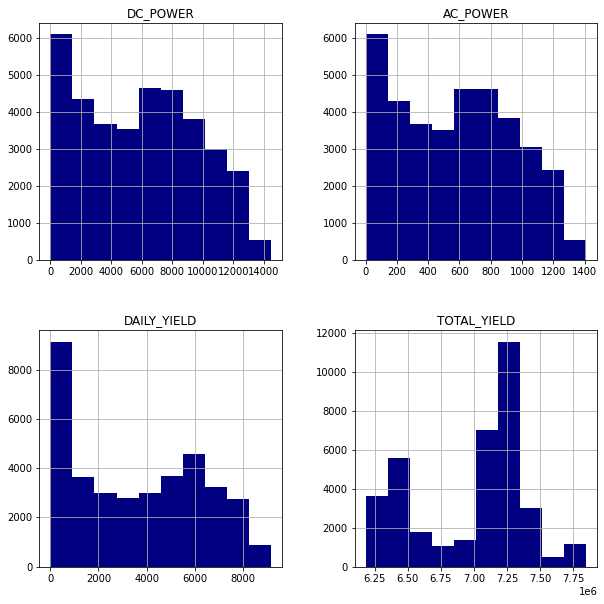

In [ ]:
# Histogram of all non zero values
sample_df = prod_p1.loc[:, prod_p1.columns != 'PLANT_ID']
sample_df = sample_df[(prod_p1['DAILY_YIELD'] > 0) & (prod_p1['AC_POWER'] > 0)]
sample_df.hist(figsize=(10,10))
plt.show()

#### Observations:
<pre>
a- Data is very clean without Null values, negatives or infinites.
b- The column names are in uppercase. They will be changed to lowercase.
c- The <b>DATE_TIME</b> column is in text format and will be converted to <i>Timestamp</i>.
d- <b>DC_POWER</b> and <b>AC_POWER</b> seems to have a scale problem since <b>DC_POWER</b> should
   be very similar to    <b>AC_POWER</b> but appears to be 10 times bigger instead.
e- <b>PLANT_ID</b> column holds a single value throughout the entire dataset, this
   column will be deleted and the value stored in an external variable to
   reduce the Data Frame memory footprint.

</pre>

In [ ]:
def optimize_formats(df):
    
    if df.columns[0].isupper():
        initial_size = getsizeof(df)
        supp_data = dict({'plant_id':0,'source_key':[]})
        
        # change column names to lowercase
        lower_case = lambda date: date.lower()
        df.columns = map(lower_case,df.columns)

        # encode "source_key" into integers, store riginal "source_key" in separate variable  
        encoder = LabelEncoder()
        encoder.fit(np.unique(df['source_key']))
        df['source_key']= np.array(encoder.transform(df['source_key'].values),dtype=np.int8)
        supp_data['source_key'] = encoder.classes_

        # delete "plant_id" column and stores it's value in an external variable"
        plant_id = df['plant_id'].values[0]
        df.drop(columns=['plant_id'],inplace=True)
        supp_data['plant_id'] = plant_id

        # change 'date_time' from string to pd.Timestamp
        df['date_time'] =pd.to_datetime(df['date_time'].values, dayfirst=True)
        final_size = getsizeof(df) + getsizeof(supp_data)
        print(f'Initial size: {initial_size/1e6:.2f} Mb')
        print(f'Final size:    {final_size/1e6:.2f} Mb')
        print(f"Memory footprint reduction: {(initial_size - final_size)/initial_size*100:.2f}%")
    else:
        raise ValueError("Formats allready optimized !")
    return df, supp_data

In [ ]:
prod_p1, prod_p1_supp_data = optimize_formats(prod_p1)

Initial size: 12.72 Mb
Final size:    2.82 Mb
Memory footprint reduction: 77.83%


In [ ]:
prod_p1_supp_data['source_key'],prod_p1_supp_data['plant_id']

(array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
        '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
        'WRmjgnKYAwPKWDb', 'YxYtjZvoooNbGkE', 'ZnxXDlPa8U1GXgE',
        'ZoEaEvLYb1n2sOq', 'adLQvlD726eNBSB', 'bvBOhCH3iADSZry',
        'iCRJl6heRkivqQ3', 'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj',
        'rGa61gmuvPhdLxV', 'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc',
        'wCURE6d3bPkepu2', 'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY',
        'zVJPv84UY57bAof'], dtype=object), 4135001)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


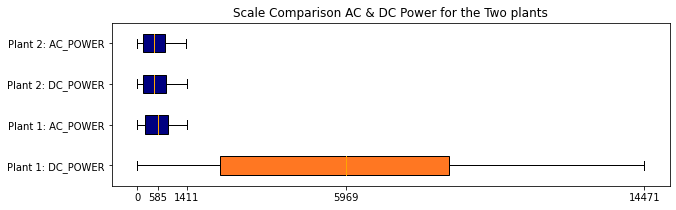

In [ ]:
# visualizing ac_power and dc_power scales without zeros

prod_p1_dc_power = prod_p1[prod_p1['dc_power'] > 0]['dc_power'].values
prod_p1_ac_power = prod_p1[prod_p1['ac_power'] > 0]['ac_power'].values

prod_p2 = pd.read_csv('/content/Plant_2_Generation_Data.csv')
prod_p2_dc_power =prod_p2[prod_p2['DC_POWER'] > 0]['DC_POWER'].values
prod_p2_ac_power =prod_p2[prod_p2['AC_POWER'] > 0]['AC_POWER'].values

data = [prod_p1_dc_power,prod_p1_ac_power,prod_p2_dc_power,prod_p2_ac_power]
labels = ['Plant 1: DC_POWER','Plant 1: AC_POWER',
            'Plant 2: DC_POWER','Plant 2: AC_POWER']
plt.figure(figsize=(10,3))
patches = plt.boxplot(data ,labels=labels,vert=False, patch_artist=True)
patches['boxes'][0].set_facecolor( '#FF7722')
plt.xticks([0,np.median(prod_p1_ac_power),prod_p1_ac_power.max(),
            np.median(prod_p1_dc_power),prod_p1_dc_power.max()])
plt.title("Scale Comparison AC & DC Power for the Two plants")

plt.show()


In [ ]:
# comparison of DC/AC power ratio (efficiency) between plants 1 & 2 

plant2_eff = 100*np.max(prod_p2_ac_power)/np.max( prod_p2_dc_power)
print(f"Power ratio AC/DC (Efficiency) plant #2: {plant2_eff:0.3f}%")
plant1_eff = 100*np.max(prod_p1_ac_power)/np.max(prod_p1_dc_power )
print(f"Power ratio AC/DC (Efficiency) plant #1:  {plant1_eff:0.3f}%")
print(f"Eff_plant_1/Eff_plant_2 (using max values): {plant2_eff/plant1_eff:.3f}")

Power ratio AC/DC (Efficiency) plant #2: 97.501%
Power ratio AC/DC (Efficiency) plant #1:  9.750%
Eff_plant_1/Eff_plant_2 (using max values): 10.000


In [ ]:
efficiency = ((prod_p2_ac_power)/np.mean(prod_p2_dc_power))/(np.mean(prod_p1_ac_power)/np.mean(prod_p1_dc_power))
print(f"Scale ratio comparison ( using mean values ): {efficiency.mean():.3f}")

Scale ratio comparison ( using mean values ): 10.001


#### Findings:
<pre>
1- In the previous visualization of <b>AC/DC</b> power can be seen the difference
   in scale. That difference in plant #1 cannot be explained by
   inefficiency due to energy losses or any other reasonable operation.
   Solar inverters efficiencies should be between <b>93%-98%.<sup><font color='blue'>[1]</font></sup></b> When comparing
   the efficiency between the two power plants (calculation above) the
   ratio is exactly 10, which means the scales are off by exactly one
   digit. Because of it the following can be deduced:
   
      <i>the differencebetween the scale of the values of <b>ac_power</b> and
      <b>dc_poewer</b> in the <b>plant #1</b> are due to an error in the decimal
      point location.</i>
   
  This can be easily corrected recalculating the <b>ac_power</b>.
</pre>

#### Refferences
<pre>
<sup><b><font color='blue'>[1]</font></b></sup><font size=2><b>"Inverter Efficiency Analysis Model Based on Solar Power
  Estimation Using Solar Radiation"</b>
  <b>Authors</b>: Park, Chul-Young, Seok-Hoon Hong, Su-Chang Lim,
  Beob-Seong Song, Sung-Wook Park, Jun-Ho Huh, and Jong-Chan Kim.
  <b>Date</b>: 2020.
  <b>Refs</b>: Processes 8, no. 10: 1225. https://doi.org/10.3390/pr8101225
</font></pre>

In [ ]:
# rescaling dc_power of plant #1
def scale_dc_power(df):
    df['dc_power'] = df['dc_power'].values/10
    return df

In [ ]:
prod_p1 = scale_dc_power(prod_p1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


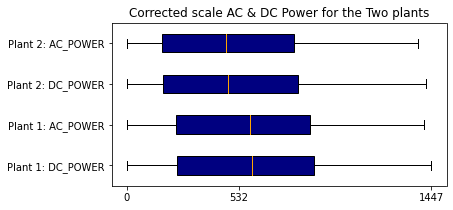

In [ ]:
prod_p1_dc_power = prod_p1['dc_power'][prod_p1['dc_power']>0].values
data2 = [prod_p1_dc_power,prod_p1_ac_power,prod_p2_dc_power,prod_p2_ac_power]
plt.figure(figsize=(6,3))
patches = plt.boxplot(data2,showfliers=False, vert=False,labels=labels, patch_artist=True)
median_2 = np.median(np.hstack(data2))
max_val_2 = prod_p1_dc_power.max()
plt.xticks([0,median_2,max_val_2])
plt.title("Corrected scale AC & DC Power for the Two plants")
# fig.tight_layout(pad=5)
plt.show()


In [ ]:
def plot_inverter(df, supp_data, key_n, start=0, end=3400):
    '''
    Visualizes the ac_power, dc_power, daily_yield and total_yield of
    an inverter in a given datetime interval
    
    returns: List of pyplot.axes for the 4 variables.
    
    Variables
    ---------
    df   : Pandas DataFrame with the production data
    key_n: int from 0 to 21 representing the inverter number
    start: int (0-3400) representing the start datetime
    end  : int (0-3400) representing the end datetime
    '''
    
    df = df.copy()
    fig_size = (12,12)
    fig = plt.figure(figsize=fig_size)
    for i,item in enumerate(['ac_power','dc_power','daily_yield',
                             'total_yield']):
        xsize,ysize = fig_size
        key_data = df[df['source_key'] == key_n].iloc[start:end]
        plt.subplot(4,1,i+1)
        plt.plot(key_data['date_time'].values, key_data[item].values,
                 linewidth=1.5,alpha=.4)
        ymin = key_data[item].values.min()
        ymax = key_data[item].values.max() 
        plt.yticks(np.linspace(ymin, ymax, 5))
#       plt.xticks(key_data['date_time'],key_data['date_time'],rotation=90)
        plt.xticks([]) # plotting the xlabels takes too much time !!!

        key  = supp_data['source_key'][key_n]
        start_date= pd.to_datetime(key_data['date_time'].iloc[0]).date()
        end_date  = pd.to_datetime(key_data['date_time'].iloc[-1]).date()
        text=f'{item}, inverter #{key_n} ({key})\nfrom {start_date} to {end_date}'
        plt.title(text, fontsize=12)
    fig.subplots_adjust(hspace=0.3)
#     plt.savefig(f'inverter_{key}.png')
    return fig.axes


In [ ]:
# a sample taken from one of the inverters
# in the arrows dict xy are pints as % of x and y axis
# in xy are 4 matrices, one for each plot 'ac_power', 'dc_power',
#         'daily_yield' & 'total_yield'

arrows =   dict({
            'saffron_arrows':
            dict({'color':'#FF7722','angle':140,
                  'xy': [[[.280,.1]],
                         [[.280,.1]],
                         [[.295,.1],[.785,.05]],
                         []]}),
            'green_arrows':
            dict({'color':'g','angle':15,
                  'xy':[[],
                        [],
                        [[.39,.79],[.64,.85],[.7,.73],[.82,.88]],
                        []]})
                })

def annotate_arrows(axes,arrows):
    for j,ax in enumerate(axes):
        for i,arrow in enumerate(arrows.values()):
            for xy_raw in arrow['xy'][j]:
                rad = lambda angle: angle/360*2*np.pi
                xmin,xmax = ax.get_xlim()
                xspan = xmax-xmin
                ymin,ymax = ax.get_ylim()
                yspan = ymax-ymin
                xy_new = np.multiply(xy_raw,[xspan,yspan])+np.array([xmin,ymin])
                xy_text= np.array(xy_new)+ np.array([
                                    0.041*np.cos(rad(arrow['angle']))*xspan,
                                    0.250*np.sin(rad(arrow['angle']))*yspan])
                ax.annotate("",xy=xy_new,xytext=xy_text,
                            arrowprops=dict(arrowstyle="->",mutation_aspect=1.2,
                            mutation_scale=15,color=arrow['color'],lw=3))

In [ ]:
#values for key_n= 14, start=200, end=1500
axes = plot_inverter(prod_p1,prod_p1_supp_data,14,start=200,end=1500)
annotate_arrows(axes, arrows)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3809a820e0> (for post_execute):


AttributeError: ignored

AttributeError: ignored

<Figure size 864x864 with 4 Axes>


#### Findings:
<pre>
2- The graph have distorted waveforms in some instances, (<font color='#FF7722' size=1><b>saffron Arrows</b></font>).
   For consequence calculations made from the data could yield inaccurate
   results.
   
3- Some <b> daily_yield</b> instances (<font color='#00AA00' size=1><b>Green Arrows</b></font>) are shorter  without the
   common top plateau, which indicates the data is not standardized. i.e.
   the <b>daily_yield</b> drops to zero at arbitrarily different times.
</pre>


#### Observations:
<pre>
f- The reason  why the graphs are distorted could be missing timestamps
   with corresponding zero values for these variables. These missing values
   should be imputed to make the wave forms regular, and the data neat for
   analysis.
   
g- Knowing that solar panels cannot produce energy in absence of light and
   that no yield can be obtained if there is no power being generated, the
   <b>daily_yield</b> can be standardized to be zero when <b>ac_power</b> is zero.
</pre>  

In [ ]:
def plot_all_ac_power(prod_df):
    '''this function plot all values for ac_power to visualize
    at which time the solar power plant begins and ends production
    to be able to separate day from night'''
    
    date_time = pd.DatetimeIndex(prod_df['date_time'].values)
    xlabels = np.unique(date_time.strftime("%H:%M"))
    date_time = date_time.hour + date_time.minute/60
    xticks =  np.unique(date_time)
    ac_power = prod_df['ac_power'].values
    plt.figure(figsize=(11,5))
    ax = plt.gca()
    ax.scatter(date_time,ac_power,s=1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels,rotation=90,fontsize=11)
    #not necesary to show all zero values !
    xmin, xmax = ax.get_xlim()
    xmin = xmin + (xmax-xmin)*0.22
    xmax = xmax - (xmax-xmin)*0.26
    plt.gca().set_xlim((xmin,xmax))
    plt.title("ac_power by hour of the day for all inverters")
    plt.show()

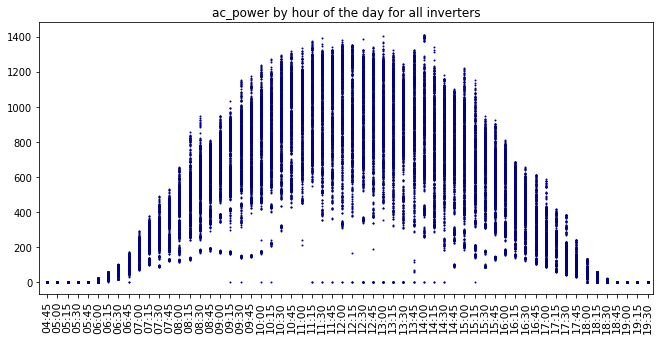

In [ ]:
plot_all_ac_power(prod_p1)

In [ ]:
date_time = pd.DatetimeIndex(prod_p1['date_time'].values)
date_time = date_time.minute/60 + date_time.hour
get_hr = lambda s : int(s.split(":")[0])+int(s.split(":")[1])/60
for s in ["05:45","06:00","18:30","18:45"]:
    answer = (prod_p1[date_time==get_hr(s)]['ac_power']>0).any()
    print(f"Is there any ac_power > 0 at {s} ?", answer)

Is there any ac_power > 0 at 05:45 ? False
Is there any ac_power > 0 at 06:00 ? True
Is there any ac_power > 0 at 18:30 ? True
Is there any ac_power > 0 at 18:45 ? False


#### Findings:
<pre>
4- There is no recorded instance of <b>ac_power</b> at 5:45; which means that
   there is no production before 5:45. For the same reason can be concluded
   that there are no production at or after 18:45.
</pre>

#### Observations:
<pre>h- From this point on the "date_time" timestamps between 6:00 and 18:30
   will be referred as <b>"Daytime hours"</b>|<b>"Day"</b> and to the ones between 18:45
   and 5:45 as <b>"Nighttime hours"</b>|<b>"Night"</b>
  
i- The values for <b>ac_power, dc_power</b> and <b>daily_yield</b> must be zero for every
   day between 18:45 and 5:45 (during the night) the <b>total_yield</b> does not
   change during these hours it can be reset to zero.

j- There isn't a safe way of imputing the missing values for daytime
   without damaging the integrity of the data, for that reason missing
   daytime values will be left untouched.

k- There are some zero values present (see plot below) when there was
   plenty of solar irradiation, those values are incompatible with normal
   operation and therefore outliers. These outliers will be eliminated
   since there should be power output even in the cloudiest days<font color='blue'><b><sup>[2]</sup></b></font>. But
   sometimes close to zero values can be found near the sunrise and sunset
   so only the values from 7:00 to 18:00 will be filtered.

</pre>

#### Refferences.
<pre>
<sup><font color="blue">[2]</font></sup><font size='2'> <b>"Increasing the solar photovoltaic enegy capture on sunny and cloudy days."</b>
    <b>Authors</b>: Nelson A. Kelly, Thomas L. Gibson
    <b>Date : </b>2010
    <b>Refs :</b> MI USA. www.elsevier.com/locate/solener
</font>

In [ ]:
# visualize daily zeros

arrows =   dict({
            'saffron_arrows1':
            dict({'color':'#FF7722','angle':140,
                  'xy': [[[.12,.05]],
                         [[.12,.05]],
                         [],
                         []]}),
            'saffron_arrows2':
            dict({'color':'#FF7722','angle':20,
                  'xy': [[[.77,.05]],
                         [[.77,.05]],
                         [],
                         []]}),
            'green_arrows':
            dict({'color':'b','angle':120,
                  'xy':[[],
                        [],
                        [[.125,.45],[.76,.32]],
                        [[.125,.12],[.76,.75]]]})
                })
axes = plot_inverter(prod_p1,prod_p1_supp_data,11,start=2070,end=3030)
annotate_arrows(axes,arrows)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3809a820e0> (for post_execute):


AttributeError: ignored

AttributeError: ignored

<Figure size 864x864 with 4 Axes>

In [ ]:

def find_missing(df):
    '''
    Function to find missing timestamps ad it's corresponding missing inverters
    find_missing(df: pandas.DataFrame)
    
    Returns pandas.DataFrame object containing the columns: 
        "date_time": missing Timestamps in "date_time" or
                     present Timestamps with missing inverters.
        "source_key" : list containing the "source_key" of the missing inverters
                     for a given Timestamp''
    Parameters
    ----------
    df: production data of solar plant'''
    
    missing_data = pd.DataFrame({})
    df = df.copy()
    
    date_time, dt_count = np.unique(df['date_time'].values,return_counts=True)
    dt_range  = pd.date_range(start=date_time[0],
                              end=date_time[-1],freq="15min")
    key = np.unique(df['source_key'].values)
    
    # find the datetimes that are not present in the datetimes of the df
    missing_data['date_time'] = dt_range[np.isin(dt_range,date_time)==False]
    source_key = [key for _ in range(len(missing_data['date_time']))]
    missing_data['source_key'] = source_key
    
    # find which inverters are missing in the datetimes that have < 22 invs.   
    dt_with_missing = date_time[dt_count < 22]
    df_missing = df[np.isin(df['date_time'].values,dt_with_missing)]
    for dt in dt_with_missing:
        present_key= df_missing[df_missing['date_time']==dt]['source_key'].values
        missing_key= key[np.isin(key,present_key)==False]
        missing_data = missing_data.append({'date_time':dt,
                            'source_key':missing_key}, ignore_index=True)
    missing_data.sort_values(by=['date_time'],ignore_index=True,inplace=True)
    return missing_data

In [ ]:
prod_p1_missing_data = find_missing(prod_p1)
prod_p1_missing_data

,date_time,source_key
0,2020-05-15 00:00:00,[7]
1,2020-05-15 00:15:00,[7]
2,2020-05-15 00:30:00,[7]
3,2020-05-15 00:45:00,[7]
4,2020-05-15 01:15:00,[7]
...,...,...
202,2020-06-06 18:45:00,"[4, 7, 9, 12, 14, 15, 16, 17, 18, 19, 20, 21]"
203,2020-06-06 19:00:00,"[4, 7, 9, 12, 14, 15, 16, 17, 18, 19, 20, 21]"
204,2020-06-06 19:15:00,"[4, 7, 9, 12, 14, 15, 16, 17, 18, 19, 20, 21]"
205,2020-06-17 06:15:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
# how many entirely missing datetimes are there?
# how many entries with missing inverters are there ?
# how many are at night and how many during the day?
    
def missing_summary(df, missing_data):
    
    df = df.copy()
    # present datetimes in the dataset
    pdt = np.unique(df['date_time'].values)
    
    # expected datetimes according to the dates in 15 min intervals
    edt = pd.date_range(start=pdt[0], end=pdt[-1],freq="15min")
    edt = len(edt)
    
    # All missing datetimes and incomplete datetimes
    mdt = pd.DatetimeIndex(missing_data['date_time'].values)
    
    # incomplete dt ( dt is present but not  for all inverters )
    idt= len(mdt) -(edt-len(pdt))
    
    # day missing datetimes
    dmdt = mdt.hour + mdt.minute/60
    dmdt = mdt[(dmdt >= 6.0) & (dmdt <= 18.5)]
    dmdt = len(dmdt)
    
    # night missing datetimes
    nmdt= len(mdt) - dmdt
    pdt = len(pdt)
    mdt = len(mdt)
    print(f"Total expected datetimes : {edt}")
    print(f"Total present datetimes  : {pdt}\n")
    text = "Total dt with missing entries or absent:"
    print(f"{text}{str(mdt).rjust(5)} ({100*mdt/edt:.2f}%)\n")
    text = "Absent dt (all inverters are missing)  :"
    print(f"{text}{str(edt-pdt).rjust(5)} ({100*(edt-pdt)/edt:.2f}%)")
    text = "Present dt with some inverters missing :"
    print(f"{text}{str(idt).rjust(5)} ({100*idt/edt:.2f}%)\n")
    text = "All dt. with missing inv. in day time  :"
    print(f"{text}{str(dmdt).rjust(5)} ({100*dmdt/edt:.2f}%)")
    text = "All dt. with missing inv. in the night :"
    print(f"{text}{str(nmdt).rjust(5)} ({100*nmdt/edt:.2f}%)")

In [ ]:
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3158

Total dt with missing entries or absent:  207 (6.34%)

Absent dt (all inverters are missing)  :  106 (3.25%)
Present dt with some inverters missing :  101 (3.09%)

All dt. with missing inv. in day time  :   55 (1.69%)
All dt. with missing inv. in the night :  152 (4.66%)


In [ ]:
#visualize how are distributed the missing datetimes in chronological order

def plot_missing_entries(prod_df, supp_data, missing_data, show_dates=False):
    
    prod_df = prod_df.copy()
    date_time = missing_data['date_time']
    night_ix = pd.DatetimeIndex(missing_data['date_time'].values)
    night_ix = night_ix.hour + night_ix.minute/60
    night_ix = (night_ix < 6.00) | (night_ix > 18.5)
    missing_matrix = np.ones((22,len(date_time)))
    for i,missing in enumerate(missing_data['source_key'].values):
        for j in np.unique(prod_df['source_key'].values):
            if j in missing:
                if night_ix[i]:
                    missing_matrix[j][i] = 0.3
                else:
                    missing_matrix[j][i] = 0
    fig = plt.figure(figsize=(len(date_time)//3.5,15))
    ax = plt.gca()
    ax.matshow(missing_matrix,aspect=2,cmap='Greys')#,vmax=0.5)
    ax.text(0,-5.4,f"Plant ID #{supp_data['plant_id']} missing entries",
            fontsize=25,c="#000066")
    subtitle = "White: Day missing, Gray: Night missing, Black: Not missing"
    ax.text(0,-3.7,subtitle,fontsize=18,c="#000066")
    ax.text(0,-4.5,"Datetimes from 15/May-2020 to 17/jun-2020",
            fontsize=18,c="#000066")
    keys = supp_data['source_key']
    plt.yticks(range(len(keys)),supp_data['source_key'],fontsize=12)
    if show_dates:
        plt.xticks(range(len(date_time)),date_time,rotation='vertical',
                   fontsize=8)
    else:
        plt.xticks([])
#     plt.savefig(f'missing_values_{supp_data["plant_id"]}.png')
    plt.show()

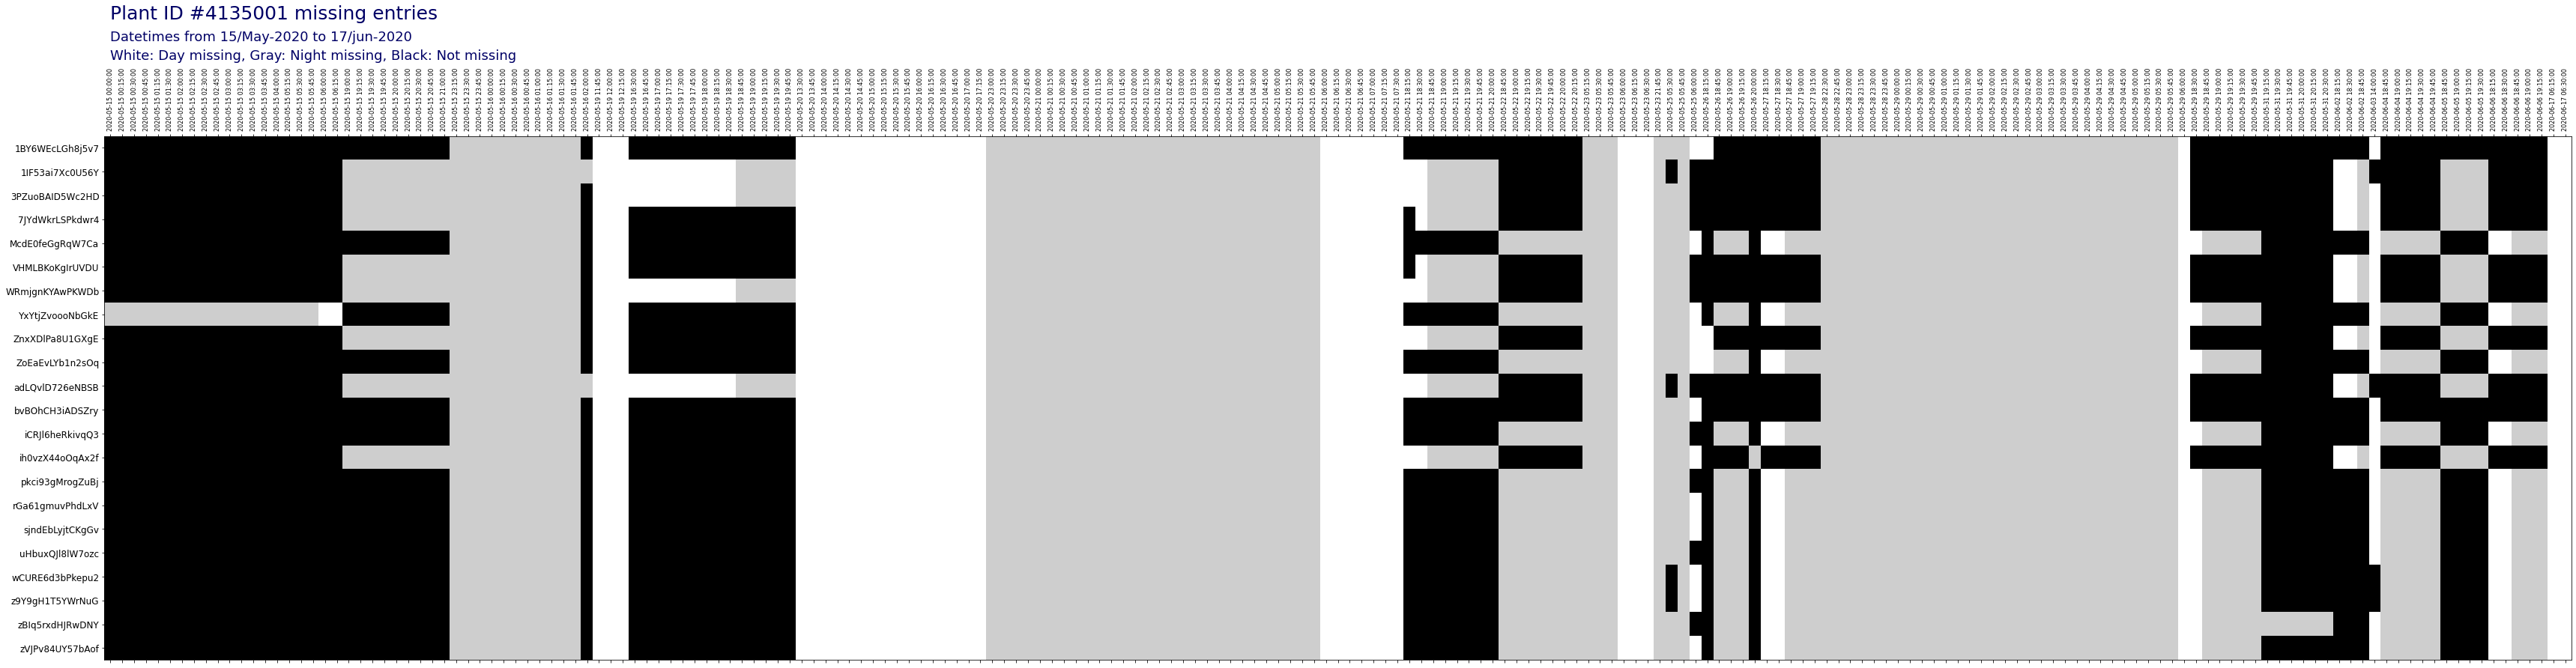

In [ ]:
'''the visualization is large so it is better to save it in a file by  unquoting
the "plt.savefig(..."  line, in the cell above and opening the file separately
or using %pylab magic command to visualize it in a separate window

Colorcode
---------
white: Daytime missing
gray : Nighttime missing
black: Not missing

Please wait ..... This visualization takes some time!'''

plot_missing_entries(prod_p1, prod_p1_supp_data, prod_p1_missing_data, show_dates=True)

#### Observations:
<pre>
l- The majority of missing values are at night, those can be easily imputed
   since there is no production at night, thus the value for power and yield is 
   zero. Inspections and maintenance can explain these missing values. On the 
   other hand these events during the day cannot be explained due to normal 
   operation if the plant was down. However there seems to be yield accumulated 
   implying the inverters and the plant were sometimes in production. But 
   whatever the reason for the missing timestamps during the day, they may be a 
   clue to some type of malfunction.

m- The missing timestamps appear to be mostly simultaneous rather than in
   individual inverters. If it is a failure then it seems to be of systemic 
   origin.
</pre>

In [ ]:
def fill_night_missing(df, missing_data):
    '''fill nighttime missing values into the DataFrame with 0 for dc_power,
    ac_power and daily_yield and the total_yield missing is replaced with the
    nearest previous value'''
    
    cols = ['date_time','source_key','dc_power','ac_power',
            'daily_yield','total_yield'] 
    new_entries = pd.DataFrame([],columns=cols)
    night_ix = pd.DatetimeIndex(missing_data['date_time'].values)
    night_ix = night_ix.hour + night_ix.minute/60
    night_ix = (night_ix < 6.00) | (night_ix > 18.5)
    night_missing = missing_data[night_ix].explode('source_key')
    for key in np.unique(night_missing['source_key'].values):
        key_data = df[df['source_key']==key]
        
        #source_key missing during the night time = skmnt
        skmnt = night_missing[night_missing['source_key']==key]['date_time'].values
        skmnt = pd.DatetimeIndex(skmnt)
        index = np.searchsorted( key_data['date_time'].values,skmnt)
        nearest_total_yield = key_data.iloc[index-1]['total_yield']
        source_key  = np.full(len(index),key, dtype=np.int8)
        zeros = np.full(len(index),0.0, dtype=np.float32)
        total_yield = np.full(len(index),nearest_total_yield, dtype=np.float32)
        intermediate_df = pd.DataFrame( zip(skmnt, source_key,
                                            zeros, zeros, zeros, total_yield),
                                            columns = cols)
        new_entries = new_entries.append(intermediate_df,ignore_index=True )
    new_entries['source_key'] = np.array(new_entries['source_key' ].values, np.int8)
    df = df.append(new_entries,ignore_index=True)
    df.sort_values(by=['date_time'],ascending=True,ignore_index=True, inplace=True)
    return df

def std_daily_yield(df):
    'replace daily_yield with zero in hours between 18:30 and 6:00'
    
    date_time = pd.DatetimeIndex(df['date_time'].values)
    date_time = date_time.hour + date_time.minute/60
    ix = np.multiply((date_time <= 18.5), (date_time >= 6))
    df['daily_yield'] = np.multiply(df['daily_yield'].values,ix)
   
    return df

In [ ]:
def remove_daytime_zeros(prod_df):
    date_time = pd.DatetimeIndex(prod_df['date_time'].values)
    date_time = date_time.hour + date_time.minute/60
    day_ix = (date_time > 6.5) & (date_time < 18)
    daytime_zeros = day_ix & (prod_df['ac_power'] <= 0)
    return prod_df[daytime_zeros == 0]

In [ ]:
prod_p1 = remove_daytime_zeros(prod_p1)
prod_p1 = fill_night_missing(prod_p1, prod_p1_missing_data)
prod_p1 = std_daily_yield(prod_p1)

In [ ]:
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3232

Total dt with missing entries or absent:   84 (2.57%)

Absent dt (all inverters are missing)  :   32 (0.98%)
Present dt with some inverters missing :   52 (1.59%)

All dt. with missing inv. in day time  :   84 (2.57%)
All dt. with missing inv. in the night :    0 (0.00%)


In [ ]:
# Exploring manually An anomalie was found in the total_yield
# in the inverter 7 (counting from 0 to 21)

plt.figure(figsize=(12,3))
sample = prod_p1[prod_p1['source_key']==7]['total_yield'].values
plt.plot(range(len(sample)),sample)
ax = [plt.gca()]
arrow =   dict({
            'saffron_arrows1':
            dict({'color':'orange','angle':0,
                  'xy': [[[.05,.5]],
                         [],
                         [],
                         []]})})
annotate_arrows(ax,arrow)
plt.show()
print("The first 4 values are greater than the 5th")
sample[0:6]

AttributeError: ignored

<Figure size 864x216 with 1 Axes>

The first 4 values are greater than the 5th


array([7425442., 7425442., 7425442., 7425442., 7179966., 7179966.])

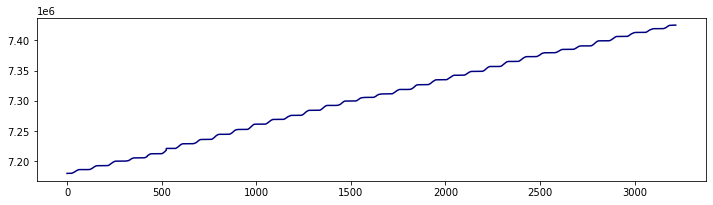

array([7179966., 7179966., 7179966., 7179966., 7179966., 7179966.])

In [ ]:
# Therefore the first 4 values will be droped for this inverter

prod_p1.drop(index=prod_p1[prod_p1['source_key']==7].iloc[:4].index,inplace=True)
plt.figure(figsize=(12,3))
sample = prod_p1[prod_p1['source_key']==7]['total_yield'].values
plt.plot(range(len(sample)),sample)
plt.show()
sample[0:6]

<a id="subsection_3_2"></a> 
<pre>
  <font color = '#FF7722'>

------------------------------------------------------------------------------
<font size='5'><b>Data Exploration preparation and insights</b></font>
------------------------------------------------------------------------------
<font size=4><b>Plant 1 Weather sensor</b></font>
</font>
</pre>

In [ ]:
p1ws = pd.read_csv('/content/Plant_1_Weather_Sensor_Data.csv')
p1ws.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [ ]:
p1ws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [ ]:
p1ws.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182.0,3182.000000,3182.000000,3182.000000
mean,4135001.0,25.531606,31.091015,0.228313
std,0.0,3.354856,12.261222,0.300836
min,4135001.0,20.398505,18.140415,0.000000
25%,4135001.0,22.705182,21.090553,0.000000
50%,4135001.0,24.613814,24.618060,0.024653
75%,4135001.0,27.920532,41.307840,0.449588
max,4135001.0,35.252486,65.545714,1.221652


#### Findings:
<pre>
5- The sensor data is formatted much like the plant 1 production data.
   The data will be reformatted in the same way.

In [ ]:
def optimize_formats_ws(df):
    if df.columns[0].isupper():
        initial_size = getsizeof(df)
        supp_data = dict({'plant_id':0,'sensors':[]})

        # drop "source_key" , store original "source_key" in separate variable
        supp_data['sensors'] = df['SOURCE_KEY'].values[0]
        df.drop(columns=['SOURCE_KEY'], inplace=True)

        # drop "plant_id" column and stores it's value in an external variable"
        supp_data['plant_id'] = df['PLANT_ID'].values[0]
        df.drop(columns=['PLANT_ID'], inplace=True)

        # change column names to lowercase, rename columns to shorter name
        df.rename(columns={'DATE_TIME':'date_time','AMBIENT_TEMPERATURE': 'ambient_t',
                           'MODULE_TEMPERATURE':'module_t', 'IRRADIATION':'irradiation'},
                 inplace=True)

        # change 'date_time' from string to pd.Timestamp
        df['date_time'] = pd.DatetimeIndex(df['date_time'].values, dayfirst=True)
        final_size = getsizeof(df) + getsizeof(supp_data)
        print(f'Initial size: {initial_size/1e6:.2f} Mb')
        print(f'Final size:    {final_size/1e6:.2f} Mb')
        print(f"Memory footprint reduction: {(initial_size - final_size)/initial_size*100:.2f}%")
    else:
        raise ValueError("Formats allready optimized !")
    return df, supp_data

In [ ]:
p1ws, p1ws_supp_data = optimize_formats_ws(p1ws)

Initial size: 0.57 Mb
Final size:    0.10 Mb
Memory footprint reduction: 82.16%


In [ ]:
p1ws.head(2)

,date_time,ambient_t,module_t,irradiation
0,2020-05-15 00:00:00,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,25.084589,22.761668,0.0


In [ ]:
p1ws_supp_data['sensors'],p1ws_supp_data['plant_id']

('HmiyD2TTLFNqkNe', 4135001)

In [ ]:
def plot_sensor(df, supp_data, start=0, end=3400,fig_size=(12,9)):
    
    df = df.copy().iloc[start:end]
    fig = plt.figure(figsize=fig_size)
    for i,item in enumerate(['ambient_t','module_t', 'irradiation']):
        xsize,ysize = fig_size
        plt.subplot(3,1,i+1)
        plt.plot(df['date_time'].values,
                    df[item].values,linewidth=1.5,alpha=0.4)
        plt.xticks([])
        sensor  = supp_data['sensors']
        start_date= pd.to_datetime(df['date_time'].iloc[0]).date()
        end_date  = pd.to_datetime(df['date_time'].iloc[-1]).date() 
        plt.title(f'{item} for sensor {sensor} from {start_date} to {end_date}',
                  fontsize=12)
#     plt.savefig(f'plant_1_sensor.png')
    return fig.axes


In [ ]:
arrows =   dict({
            'saffron_arrows':
            dict({'color':'#FF7722','angle':290,
                  'xy': [[[.38,.2]],[],[]]}),
            'saffron_arrows2':
            dict({'color':'#FF7722','angle':120,
                  'xy': [[],[[.37,.1]],[[.37,.1]]]})
                })
axes = plot_sensor(p1ws,p1ws_supp_data, start=200,end=1200)
annotate_arrows(axes,arrows)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3809a820e0> (for post_execute):


AttributeError: ignored

AttributeError: ignored

<Figure size 864x648 with 3 Axes>

#### Findings:
<pre>
6- There seems to be missing timestamps in the sensor data as well
(<font color='#FF7722' size=1><b>saffron Arrows</b></font>).
</pre>

#### Observations:
<pre>
n- Since we are not going to perform calculations over this data, unlike
   the production data, these missing timestamps are going to be left
   untouched.
</pre>

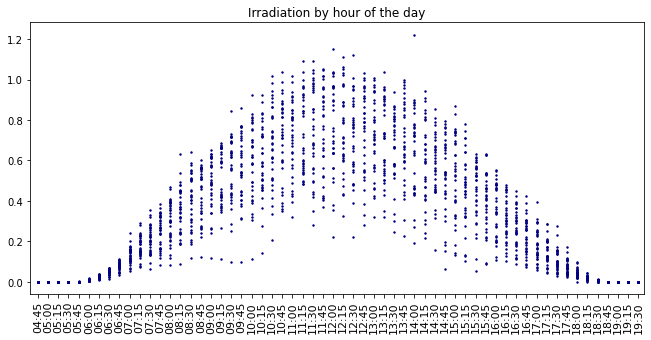

In [ ]:
# visualize distribution of irradiation by hour
def plot_irradiation(sensor_df):
    df = sensor_df.copy()
    ir = df['irradiation'].values
    plt.figure(figsize=(11,5))
    date_time = pd.DatetimeIndex(df['date_time'].values)
    xlabels = np.unique(date_time.strftime("%H:%M"))
    date_time = date_time.hour + date_time.minute/60
    xticks = np.unique(date_time)
    plt.xticks(xticks,xlabels,rotation=90,fontsize=11)
    plt.scatter(date_time,ir,s=2)
    xmin, xmax = plt.gca().get_xlim()
    xmin = xmin + (xmax-xmin)*0.22
    xmax = xmax - (xmax-xmin)*0.26
    plt.gca().set_xlim((xmin,xmax))
    plt.title("Irradiation by hour of the day")
    plt.show()
plot_irradiation(p1ws)

In [ ]:
date_time = pd.DatetimeIndex(p1ws['date_time'].values)
date_time = date_time.minute/60 + date_time.hour
get_hr = lambda string : int(string.split(":")[0])+int(string.split(":")[1])/60
for text_time in ["05:45","06:00","18:30","18:45"]:
    answer = (p1ws[date_time==get_hr(text_time)]['irradiation'] > 0).any()
    print(f"Is there any irradiation > 0 at {text_time} ?", answer)

Is there any irradiation > 0 at 05:45 ? True
Is there any irradiation > 0 at 06:00 ? True
Is there any irradiation > 0 at 18:30 ? True
Is there any irradiation > 0 at 18:45 ? True


#### Findings:
<pre>
7- In the visualization above is clear that irradiation is zero between 
   18:45 and 5:45 but in a closer inspection there are values other than 
   zero before 6:00 and also after 18:30. Those values might correspond to 
   high sensitivity of the sensor, but irradiation too low to be usable by
   the photovoltaic panels. For practical purposes those values can be
   considered as zeros and the day/night interval established before 
   remains the same.
</pre>

<a id="subsection_3_3"></a> 
<pre>
  <font color = '#FF7722'>

------------------------------------------------------------------------------
<font size='5'><b>Data Exploration preparation and insights</b></font>
------------------------------------------------------------------------------
<font size=4><b>Plant 2 Production Data</b></font>
</font>
</pre>

In [ ]:
# prod_p2 id for production of plant #2
prod_p2 = pd.read_csv('/content/Plant_2_Generation_Data.csv')
prod_p2[prod_p2['DC_POWER']>0].head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
528,2020-05-15 06:00:00,4136001,4UPUqMRk7TRMgml,15.406667,14.860000,0.800000,2.429012e+06
529,2020-05-15 06:00:00,4136001,81aHJ1q11NBPMrL,14.773333,14.246667,0.733333,1.215279e+09
530,2020-05-15 06:00:00,4136001,9kRcWv60rDACzjR,15.380000,14.840000,1.866667,2.247720e+09
531,2020-05-15 06:00:00,4136001,Et9kgGMDl729KT4,14.973333,14.440000,1.000000,1.704251e+06
532,2020-05-15 06:00:00,4136001,IQ2d7wF4YD8zU1Q,15.160000,14.633333,0.733333,1.994153e+07


In [ ]:
prod_p2[prod_p2['DC_POWER']>0].tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
67253,2020-06-17 18:45:00,4136001,q49J1IKaHRwDQnt,3.771429,3.635714,4156.857143,5.207579e+05
67254,2020-06-17 18:45:00,4136001,rrq4fwE8jgrTyWY,2.857143,2.757143,3930.714286,1.211314e+08
67255,2020-06-17 18:45:00,4136001,vOuJvMaM2sgwLmb,3.780000,3.633333,4321.800000,2.427691e+06
67256,2020-06-17 18:45:00,4136001,xMbIugepa2P7lBB,3.580000,3.453333,4217.733333,1.068964e+08
67257,2020-06-17 18:45:00,4136001,xoJJ8DcxJEcupym,3.907143,3.757143,4315.642857,2.093357e+08


In [ ]:
prod_p2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB


In [ ]:
prod_p2.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09


#### Observations:
<pre>
o- Data is also clean, with the same features as plant 1, will be formatted
   the same way
</pre>

In [ ]:
prod_p2, prod_p2_supp_data = optimize_formats(prod_p2)

Initial size: 12.73 Mb
Final size:    2.78 Mb
Memory footprint reduction: 78.19%


In [ ]:
prod_p2_supp_data['source_key'],prod_p2_supp_data['plant_id']

(array(['4UPUqMRk7TRMgml', '81aHJ1q11NBPMrL', '9kRcWv60rDACzjR',
        'Et9kgGMDl729KT4', 'IQ2d7wF4YD8zU1Q', 'LYwnQax7tkwH5Cb',
        'LlT2YUhhzqhg5Sw', 'Mx2yZCDsyf6DPfv', 'NgDl19wMapZy17u',
        'PeE6FRyGXUgsRhN', 'Qf4GUc1pJu5T6c6', 'Quc1TzYxW2pYoWX',
        'V94E5Ben1TlhnDV', 'WcxssY2VbP4hApt', 'mqwcsP2rE7J0TFp',
        'oZ35aAeoifZaQzV', 'oZZkBaNadn6DNKz', 'q49J1IKaHRwDQnt',
        'rrq4fwE8jgrTyWY', 'vOuJvMaM2sgwLmb', 'xMbIugepa2P7lBB',
        'xoJJ8DcxJEcupym'], dtype=object), 4136001)

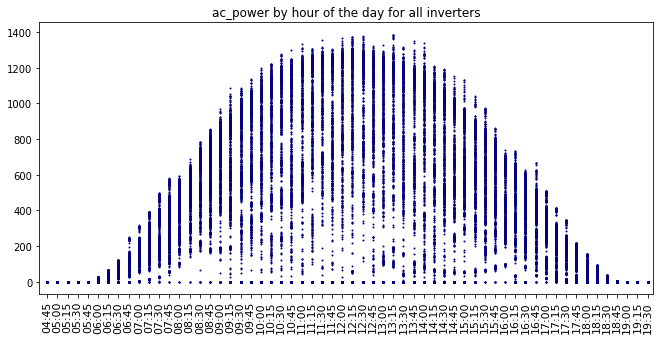

In [ ]:
plot_all_ac_power(prod_p2)

In [ ]:
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3259

Total dt with missing entries or absent:  909 (27.85%)

Absent dt (all inverters are missing)  :    5 (0.15%)
Present dt with some inverters missing :  904 (27.70%)

All dt. with missing inv. in day time  :  485 (14.86%)
All dt. with missing inv. in the night :  424 (12.99%)


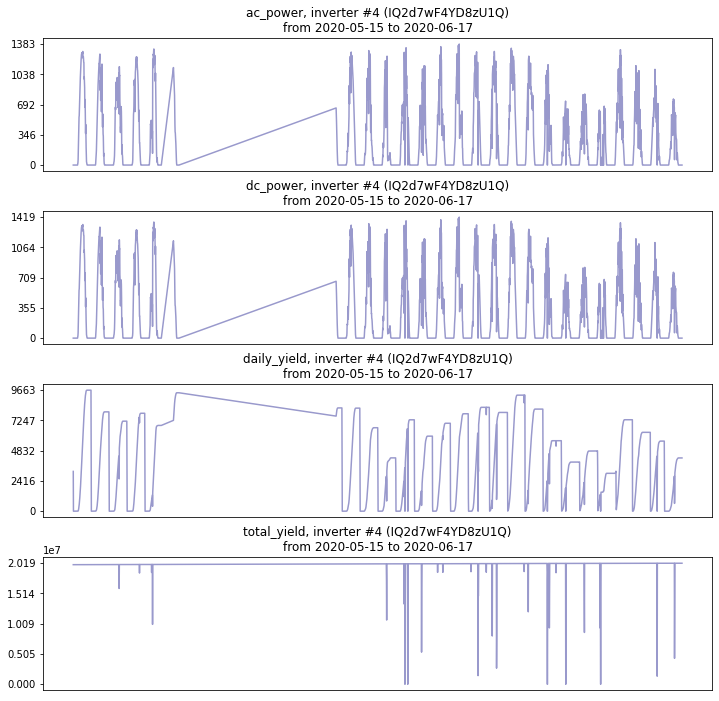

In [ ]:
_ = plot_inverter(prod_p2,prod_p2_supp_data,4,start=0)


#### Findings:
<pre>
8- We have similar situations to those encountered in the plant 1
   production dataset:
      • Missing timestamps during day and during night
      • Production starts and ends at 6:00 and 18:30 respectively.
   Additionally we encounter many anomalies in the <b>total_yield</b>  (see plot
   above) that appear as very pronounced peaks pointing downwards.
   Other anomalies seems to happen simultaneously in the <b>daily_yield</b>.
   It looks easier to filter them in the <b>total_yield</b>.
</pre>

In [ ]:
# Fill the night-missing time-stamps with zeros for plant #2
prod_p2 = fill_night_missing(prod_p2, prod_p2_missing_data)

# Actualize the missing values after night-missing are filled
prod_p2_missing_data = find_missing(prod_p2)

# Standardize daily_yield to be zero when there is no longer production
prod_p2 = std_daily_yield(prod_p2)

# Remove zero or negative outliers from daytime
prod_p2 = remove_daytime_zeros(prod_p2)

# Actualize the missing values after night-missing are filled
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3248

Total dt with missing entries or absent:  858 (26.29%)

Absent dt (all inverters are missing)  :   16 (0.49%)
Present dt with some inverters missing :  842 (25.80%)

All dt. with missing inv. in day time  :  858 (26.29%)
All dt. with missing inv. in the night :    0 (0.00%)


#### Observations:
<pre>
p- To filter out the anomalies of the total_yield where: </pre>
$$ total\_yield_i < total\_yield_{i-1} \color{white}{--------------------}$$
<pre>   we will take the difference between each contiguous pairs of values for
   each inverter and drop the record when the difference is negative:</pre>
$$ total\_yield_i - total\_yield_{i-1} < 0 \color{white}{--------------------}$$   


In [ ]:
def filter_total_yield_anomalies(prod_df, variable):
    new_ix = [] #list of the indexes without anomalies
    for key in np.unique(prod_df['source_key'].values):
        key_df = prod_df[prod_df['source_key']==key]
        field = key_df[variable].values
        if variable == 'daily_yield':
                field = np.cumsum(field)
        filter_ix = (field[1:]-field[0:-1]) < 0
        present_outliers = np.any(filter_ix == True)
        while present_outliers:
            dt = pd.DatetimeIndex(key_df['date_time'].values)
            field = key_df[variable].values
            if variable == 'daily_yield':
                field = np.cumsum(field)
            filter_ix = np.hstack([[False],(field[1:]-field[0:-1]) < 0])
            key_df = key_df[filter_ix == False]
            field = key_df[variable].values
            filter_ix = np.hstack([(field[1:]-field[0:-1]) < 0,[False]])
            present_outliers = np.any(filter_ix == True)
        new_ix += list(key_df.index)
    new_ix = list(np.sort(new_ix))
    init = len(prod_df.index)
    end  = len(new_ix)
    print(f'Initial Dataframe Length: {init}')
    print(f'Final Dataframe length: {end}')
    print(f'filtered out records: {init-end} ({(init-end)/init*100:.1f}%)')
    return prod_df.loc[new_ix,:]

Initial Dataframe Length: 65739
Final Dataframe length: 64098
filtered out records: 1641 (2.5%)


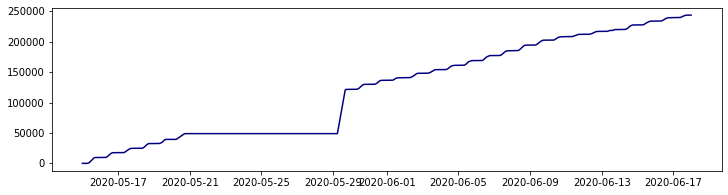

In [ ]:
prod_p2 = filter_total_yield_anomalies(prod_p2,'total_yield')
sample = prod_p2[prod_p2['source_key']==4]
dt = sample['date_time'].values
plt.figure(figsize=(12,3))
ty = sample['total_yield'].values
plt.plot(dt,ty-ty.min())
plt.show()

#### Observations:
<pre>
q- Now the <b>total_yield</b> looks like a cumulative function without anomalies
   much like the behaviour of any inverter of the plant #1. 
   The same can be done for the <b>total yield</b> of the plant #1 
</pre>


Initial Dataframe Length: 70874
Final Dataframe length: 70823
filtered out records: 51 (0.1%)


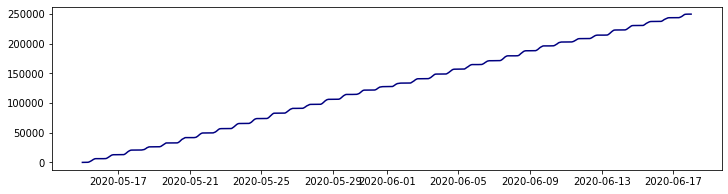

In [ ]:
prod_p1 = filter_total_yield_anomalies(prod_p1,'total_yield')
sample = prod_p1[prod_p1['source_key']==2]
dt = sample['date_time'].values
plt.figure(figsize=(12,3))
ty = sample['total_yield'].values
plt.plot(dt,ty-ty.min())
plt.show()

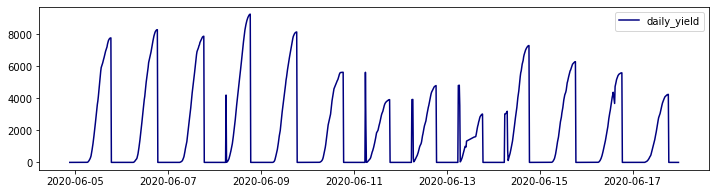

In [ ]:
sample = prod_p2.copy()[prod_p2['source_key']==4]
dt = pd.DatetimeIndex(sample['date_time'].values)
plt.figure(figsize=(12,3))
daily_yield = sample['daily_yield'].values
n=1500
m=3500
plt.plot(dt[n:m], daily_yield[n:m], label='daily_yield')
plt.legend()
plt.show()

#### Observations:
<pre>
r- Despite of filtering out anomalies on the <b>daily_yield</b> when the
   <b>total_yield</b> was filtered, some anomalies in the <b>daily_yield</b> remains. To
   filter out the <b>daily_yield</b> anomalies a similar ptocedure can be applied to
   find them.:
</pre>
$$daily\_yield_{i+1}-daily\_yield_i<0 \quad\land\quad daily\_yield_{i+1}\neq 0 \color{white}{-------------}$$

In [ ]:
def filter_daily_yield_anomalies(prod_df):
    df = prod_df.copy()
    initial_size = len(df)
    
    def get_filter_values(sub_df):
        dt = pd.DatetimeIndex(sub_df['date_time'].values)
        daily_yield = sub_df['daily_yield'].values
        delta = np.hstack([[0],daily_yield[1:]-daily_yield[0:-1]])
        # 
        periods = np.hstack([ [1], (dt[1:] - dt[0:-1]).seconds/900])
        delta = delta/periods
        return (delta < 0) & (daily_yield != 0)
        
    for key in np.unique(df['source_key'].values):
        key_df = df[df['source_key'] == key]
        yield_filter = get_filter_values(key_df)
        ix_to_drop = []
        while np.any(yield_filter):
            key_ix = key_df.index
            bad_ix = [ key_ix[key_ix < ix][-1] for ix in  key_ix[yield_filter]]
            ix_to_drop += bad_ix
            key_df = key_df.drop(bad_ix)
            yield_filter = get_filter_values(key_df)
        df.drop(ix_to_drop, inplace=True)
    print(f"Dataset reduction: {(initial_size-len(df))/initial_size*100:0.2f}%")
    return df

In [ ]:
prod_p2 = filter_daily_yield_anomalies(prod_p2)

Dataset reduction: 0.72%


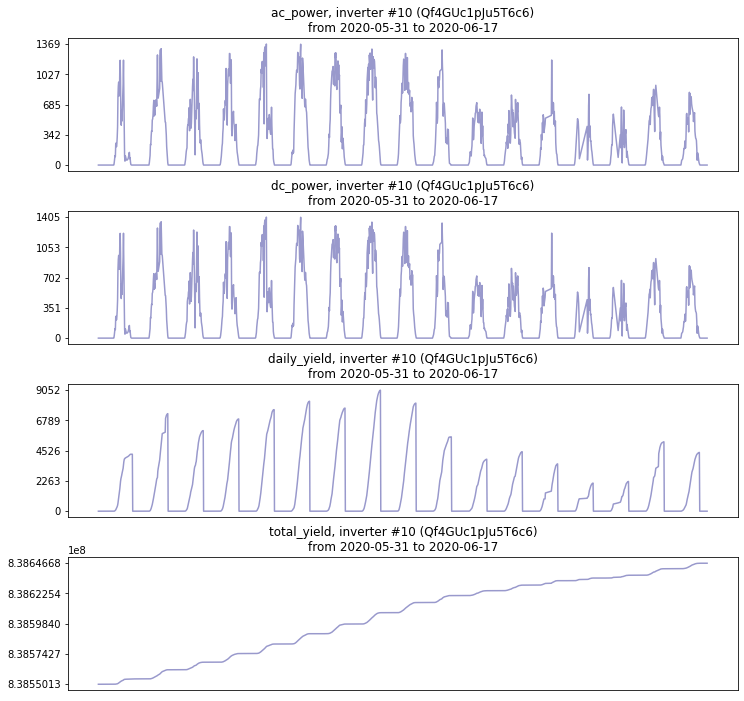

In [ ]:
_ = plot_inverter(prod_p2,prod_p2_supp_data,10,start=1500)

#### Observations:
<pre>
s- The data looks neat, tiddy and pristine clean for analysis now, the
   filtering-out of the <b>daily_yiel</b> will also be applied throughout
   the plant #1 production dataset as a prophylactic precaution.
</pre>

In [ ]:
prod_p1 = filter_daily_yield_anomalies(prod_p1)

Dataset reduction: 0.08%


In [ ]:
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3211

Total dt with missing entries or absent: 1505 (46.11%)

Absent dt (all inverters are missing)  :   53 (1.62%)
Present dt with some inverters missing : 1452 (44.49%)

All dt. with missing inv. in day time  : 1122 (34.38%)
All dt. with missing inv. in the night :  383 (11.73%)


Note: The filtering have erased some of the values that
should be zero, reimputing them is a must.

In [ ]:
prod_p2 = fill_night_missing(prod_p2, prod_p2_missing_data)
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3211

Total dt with missing entries or absent: 1122 (34.38%)

Absent dt (all inverters are missing)  :   53 (1.62%)
Present dt with some inverters missing : 1069 (32.75%)

All dt. with missing inv. in day time  : 1122 (34.38%)
All dt. with missing inv. in the night :    0 (0.00%)


In [ ]:
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3231

Total dt with missing entries or absent:  115 (3.52%)

Absent dt (all inverters are missing)  :   33 (1.01%)
Present dt with some inverters missing :   82 (2.51%)

All dt. with missing inv. in day time  :   87 (2.67%)
All dt. with missing inv. in the night :   28 (0.86%)


In [ ]:
prod_p1 = fill_night_missing(prod_p1, prod_p1_missing_data)
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes : 3264
Total present datetimes  : 3231

Total dt with missing entries or absent:   87 (2.67%)

Absent dt (all inverters are missing)  :   33 (1.01%)
Present dt with some inverters missing :   54 (1.65%)

All dt. with missing inv. in day time  :   87 (2.67%)
All dt. with missing inv. in the night :    0 (0.00%)


<a id="subsection_3_4"></a> 
<pre>
  <font color = '#FF7722'>

------------------------------------------------------------------------------
<font size='5'><b>Data Exploration preparation and insights</b></font>
------------------------------------------------------------------------------
<font size=4><b>Plant 2 Weather sensor Data</b></font>
</font>
</pre>

In [ ]:
p2ws = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')
p2ws.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [ ]:

p2ws, p2ws_supp_data = optimize_formats_ws(p2ws)

Initial size: 0.59 Mb
Final size:    0.10 Mb
Memory footprint reduction: 82.16%


In [ ]:
display(p2ws.head(2))

,date_time,ambient_t,module_t,irradiation
0,2020-05-15 00:00:00,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,26.880811,24.421869,0.0


In [ ]:
p2ws_supp_data

{'plant_id': 4136001, 'sensors': 'iq8k7ZNt4Mwm3w0'}

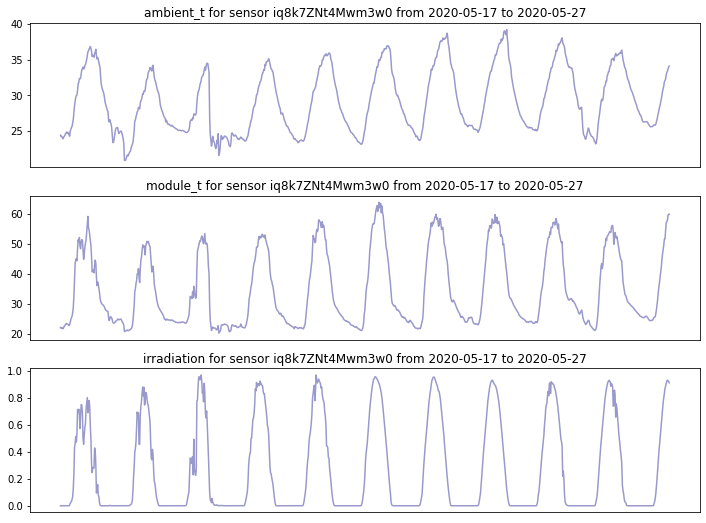

In [ ]:
_ = plot_sensor(p2ws,p2ws_supp_data, start=200,end=1200)

#### Observations:
<pre>t- Sensor data for plant #2 is neat and tiddy enough for analysis purposes</pre>

<a id="section_4"></a> 
<pre>
  <font color = '#FF7722'>

------------------------------------------------------------------------------
<font size='5'><b>Photovoltaic power plant theoretical model</b></font>
------------------------------------------------------------------------------
</font>
</pre>

#### Variables
$\quad T_m\;$ : Module temperature.<br>
$\quad T_a\;$ : Ambient temperature.<br>
$\quad G_{ir}$ : Ground level sun irradiance or Irradiation.<br>
$\quad P_{ac}$ : Power output (AC power).<br>

#### Constants.
$\quad T_0\;$ : 25<sup>o</sup>C.<br>
$\quad G_0$ : Standard Irradiation 1000 W/m<sup>2</sup>.<br>
$\quad \alpha\;\;$ : Module electrical specification.<br>
$\quad \beta\;\;$ : Module electrical specification.<br>
$\quad V_{0}$ : Open circuit Voltage at <b>St</b>andard <b>C</b>onditions.<br>
$\quad I_{0}$ : Short circuit Current at <b>St</b>andard <b>C</b>onditions.
<pre>**STC conditions:  25<sup>o</sup>C and 1000 W/m<sup>2</sup></pre>

#### Physics Model.
<pre>
The photovoltaic power output of <b>Pac</b> (taking into account the inverter) can
be modeled from the product of the open circuit voltage <font size=4><b>V<sub>th</sub></b></font> (Thèvenin 
voltage) and the short circuit current <font size=4><b>I<sub>no</sub></b></font> (Mayer-Norton current):
</pre>
$\quad\quad P_{ac}=V_{th}\cdot I_{no}{\color{white}{-------------------------}}(1)$
<pre>
And the <font size=4><b>V<sub>th</sub>, I<sub>no</sub></b></font> are defined by<sup><font color="blue">[3]</font></sup>:

</pre>
$\quad\quad V_{th}=V_{0}[1+\beta(T_m-T_0)] {\color{white}{--------------------\;}}(2)$

$\quad\quad I_{no}=I_{0}[1+\alpha(T_m-T_0)]\Big( \frac{G_{ir}}{G_0} \Big) {\color{white}{------------------}}(3)$
<pre>
The module temperature is directly proportional to the Irradiation and to
the ambient temperature and can be represented by the following empirical
formula<sup><font color="blue">[4]</font></sup>
</pre>
$\quad\quad T_{m}=30-0.0175(G_{ir}-300)+1.14(T_{a}-25) {\color{white}{-----------}}(4)$
<pre>
replacing equations <b>(2), (3)</b> and <b>(4)</b> into equation <b>(1)</b> we then get a third
degree polynomial that can be expressed as follows:
</pre>
$\quad\quad P_{ac}= {K_1}{\color{orange}{G_{ir}^3}}+ {K_2}{\color{orange}{G_{ir}^2}}+ {K_3}{\color{orange}{G_{ir}^2T_a}}+ {K_4}{\color{orange}{G_{ir}T_a^2}}+ {K_5}{\color{orange}{G_{ir}T_a}}+ {K_6}{\color{orange}{G_{ir}}}{\color{white}{---}}(5)$

<pre>
Where <font size=4><b>K<sub>1</sub>, K<sub>2</sub>, ... , K<sub>6</sub></b></font> are constants.
</pre>
<pre>
With the equation <b>(5)</b> we now know which new features we have to create in
order to build a regressor that predicts <b>AC Power</b>. They are highlighted in
<font color='orange'>orange</font>.
Note that this equation have an intercept = 0 in the <font size=4><b>P<sub>ac</sub></b></font> axis
</pre>

#### Refferences.
<pre>
<sup><font color="blue">[3]</font></sup><font size='2'><b>"A novel Power Output Model for Photovoltaic Systems."</b>
    <b>Authors</b>: Chiou-Jye Huang, Mao Ting Huang, Chung-Cheng Chen, .
    <b>Date : </b>2013
    <b>Refs :</b> Taiwan, DOI: 10.12720/sgce.2.2.139-147
</font>
<sup><font color="blue">[4]</font></sup><font size='2'><b> "Photovoltaic Engineering Handbook."</b>
    <b>Authors</b>: France Lasnier, Tony Gan Ang.
    <b>Date : </b>1990
    <b>Refs :</b> USA, ISBN: 9780203743393
</font>

</pre>


<a id="section_5"></a>
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>plant #1 Power modeling and prediction.</b></font>
------------------------------------------------------------------------------
</font>
</pre>

In [ ]:
def power_vs_irr_vs_temp(sensor_df,prod_df,key):
    key_df = pd.merge(left=sensor_df,right=prod_df,
                      how='inner',on='date_time')
    key_df = key_df[key_df['source_key']==key]
    date_time = pd.DatetimeIndex(key_df['date_time'].values)
    date_time = date_time.hour + date_time.minute/60
    day_ix = (date_time >= 6) & (date_time <= 18.5)
    key_df = key_df[day_ix]
    key_df.drop(columns=key_df.columns.difference(['date_time','ambient_t',
                    'module_t','irradiation','ac_power']),inplace=True)
    key_df = key_df.sort_values(by=['irradiation'])
    fig = plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    color_index = np.unique(key_df['irradiation'].values/(1.1*key_df['irradiation'].max())+0.1)
    colors = plt.cm.Greens(X=color_index)[-1::-1]
    ax.scatter(key_df['ambient_t'],key_df['ac_power'],color= colors,alpha=1)
    ax.set_title("AC Power Vs Ambient Temperature Plant #1")
    ax.set_xlabel("Ambient Temperature")
    ax.set_ylabel("AC Power (Kw)",labelpad=30)
    ax.yaxis.get_label().set_rotation(-90)
    plt.colorbar( plt.cm.ScalarMappable(norm=Normalize(vmax=0.0,vmin=1.2),
                        cmap='Greens_r'), ticks=np.arange(0,1.21,0.2),label='Irradiation (W / $m^2$)')

    fig.add_subplot(1,2,2,projection='3d')
    ax = plt.gca()
    ax.scatter(key_df['ambient_t'],key_df['irradiation'].values,key_df['ac_power'])
    ax.view_init(elev=30,azim=-140)
    ax.set_xlabel('Ambient Temperature (ºC)')
    ax.set_ylabel('Irradiation (W / $m^2$)')
    ax.set_zlabel('AC Power (Kw)')
    ax.zaxis.get_label().set_rotation(1)
    ax.set_title('AC Power Vs abient_t & Irradiation Plant #1 inv #1 ')
    plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


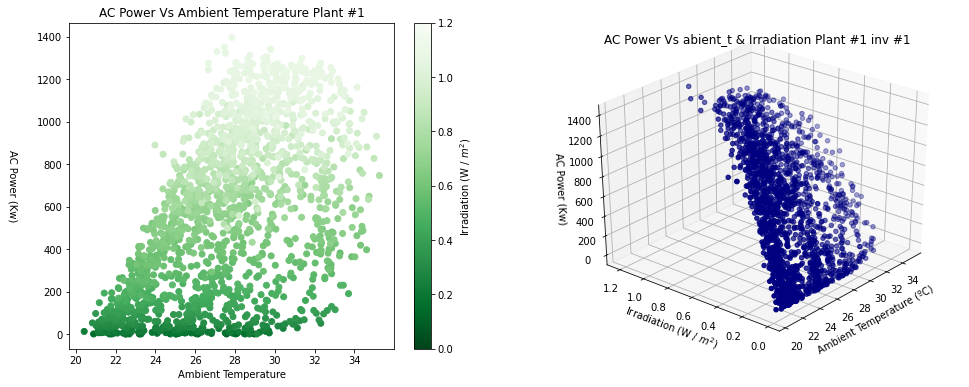

In [ ]:
power_vs_irr_vs_temp(p1ws,prod_p1,21)

#### Observations:
<pre>
u- A clear positive relation between <b>Irradiance</b> and <b>ac_power</b> can be
   observed as predicted by the physics model. Although the relation
   with ambient temp. is not so clear because it is also dependent
   on irradiation.
   
v- We will proceed in the following fashion:
     • Create the new features required according to the physiscs model.
     • Split the data for each inverter into training and test sets.
     • Find a good regressor for the purpose of modeling.
     • Train a regressor for each inverter and test its performances over
       the test sets.
</pre>


In [ ]:
def create_new_features(prod_df,sensor_df,key_n):
    df = prod_df.copy()[prod_df['source_key']==key_n]
    df = pd.merge(left=sensor_df,right=df,how='inner',on='date_time')
    hours = pd.DatetimeIndex(df['date_time'].values)
    hours = hours.hour + hours.minute/60
    df = df[(hours >= 6) & (hours <= 18.5)]
    df.rename(columns={'irradiation':'Gir','ac_power':'pac', 
                       'ambient_t': 'Ta'}, inplace=True)
    df = df[['date_time','source_key','Gir','Ta','pac']]
    df['hours'] = hours[(hours >= 6) & (hours <= 18.5)]
    df['Gir^3'] = np.power(df['Gir'],3)
    df['Gir^2'] = np.power(df['Gir'],2)
    df['Ta^2']  = np.power(df['Ta'],2)
    df['Gir^2.Ta'] = np.multiply(df['Gir^2'],df['Ta'])
    df['Gir.Ta^2'] = np.multiply(df['Gir'],df['Ta^2'])
    df['Gir.Ta'] =  np.multiply(df['Gir'],df['Ta'])
    df = df[['date_time','hours','Gir^3','Gir^2','Gir^2.Ta','Gir.Ta^2',
                     'Gir.Ta','Gir','pac']]
                     
    return df

In [ ]:
prod_p1_new_data = create_new_features(prod_p1,p1ws,1)
prod_p1_new_data.head()

,date_time,hours,Gir^3,Gir^2,Gir^2.Ta,Gir.Ta^2,Gir.Ta,Gir,pac
24,2020-05-15 06:00:00,6.00,2.040199e-07,0.000035,0.000835,3.415926,0.141808,0.005887,5.162500
25,2020-05-15 06:15:00,6.25,1.106215e-05,0.000496,0.011921,12.846653,0.535018,0.022282,30.014286
26,2020-05-15 06:30:00,6.50,1.206250e-04,0.002441,0.058535,28.404842,1.184684,0.049410,69.200000
27,2020-05-15 06:45:00,6.75,8.680992e-04,0.009100,0.220395,55.954521,2.310357,0.095394,130.142857
28,2020-05-15 07:00:00,7.00,2.859687e-03,0.020147,0.494357,85.460059,3.482849,0.141940,195.100000


In [ ]:
def split_data(df):
    X = df.drop(columns=['hours','pac'])
    pac = df['pac'].values
    train_size = int(0.8*len(pac))
    X_train ,  X_test  =   X.iloc[:train_size,:],   X.iloc[train_size:,:];
    pac_train, pac_test= pac[:train_size],   pac[train_size:];
    #filter out pac=0
    ix = pac_test > 0
    pac_test = pac_test[ix]
    X_test = X_test[ix]
    return X_train, X_test, pac_train, pac_test;


In [ ]:
X_train, X_test, pac_train, pac_test = split_data(prod_p1_new_data)

In [ ]:
def find_best_regressor(X_train, pac_train):
    X_train = X_train.drop(columns=['date_time']).values
    models = [
            ('Linear', LinearRegression(fit_intercept =False, normalize=False, n_jobs=-1)),
            ('Ridge', Ridge(fit_intercept =False, solver= 'lsqr', random_state=1973)),
            ('DTree', DecisionTreeRegressor(random_state=1973)),
            ('RForest', RandomForestRegressor(random_state=1973, n_jobs=-1)),
            ('KNReg', KNeighborsRegressor(n_neighbors=5,n_jobs=-1)),
            ]
    scores = dict({})
    ts_split = TimeSeriesSplit(n_splits=6)
    for name,model in models:
        folds = ts_split.split(X_train, pac_train)
        regressor = clone(model)
        cv_scores = cross_validate(regressor, X_train, pac_train,
                                   cv=folds, scoring='neg_mean_squared_error')
        scores[name.rjust(10," ")] = np.mean(cv_scores['test_score'])
    scores = pd.DataFrame(scores.items(),columns=['regressor','Neg_MSE'])
    scores = scores.sort_values(by=['Neg_MSE'],ascending=False,ignore_index=True)
    return scores

In [ ]:
find_best_regressor(X_train, pac_train )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave 

,regressor,Neg_MSE
0,Linear,-3296.166947
1,Ridge,-3329.263643
2,RForest,-4067.455598
3,DTree,-6769.461600
4,KNReg,-9986.437094


In [ ]:
def construct_models(prod_df,sensor_df):
    models = []
    predictions_df = pd.DataFrame({})
    rmse = []
    def get_final_model(X, X_t, pac, pac_t):
        model = LinearRegression()
        model.fit(X, pac)
        pac_pred = model.predict(X_t).flatten()
        return model, pac_pred, mean_squared_error(pac_t, pac_pred)
    
    for key in np.unique(prod_df['source_key'].values):
        new_features = create_new_features(prod_df,sensor_df,key)
        X_train, X_test, pac_train, pac_test = split_data(new_features)
        date_time = X_test['date_time'].values
        X_train = X_train.drop(columns=['date_time']).values
        X_test  = X_test.drop(columns=['date_time']).values
        model, pac_predicted, mse = get_final_model(X_train, X_test,
                                                    pac_train, pac_test)
        models += [model]
        rmse += [np.sqrt(mse)]
        r2score = int(100*r2_score(pac_test,pac_predicted))
        residuals = (pac_predicted-pac_test)
        str1 = f'#{str(key).rjust(2)}   --->   '
        str2 = f' rmse: {int(np.sqrt(mse))}'
        str3 = f',      R^2 (Determination coeff.): {r2score}%'
        print( str1 + str2 +str3)
        predictions_df = predictions_df.append(
            pd.DataFrame({
              'date_time':date_time,'source_key':np.full(len(residuals),key),
              'pac':pac_test, 'pac_predicted':pac_predicted,
              'residuals':residuals  })  )
    predictions_df.sort_values(by='date_time', ignore_index=True, inplace=True)
    return models, predictions_df, rmse

In [ ]:
( plant1_models, plant1_predictions,
plant1_rmses ) = construct_models(prod_p1, p1ws)

# 0   --->    rmse: 66,      R^2 (Determination coeff.): 95%
# 1   --->    rmse: 41,      R^2 (Determination coeff.): 98%
# 2   --->    rmse: 49,      R^2 (Determination coeff.): 97%
# 3   --->    rmse: 42,      R^2 (Determination coeff.): 98%
# 4   --->    rmse: 42,      R^2 (Determination coeff.): 98%
# 5   --->    rmse: 45,      R^2 (Determination coeff.): 98%
# 6   --->    rmse: 53,      R^2 (Determination coeff.): 97%
# 7   --->    rmse: 40,      R^2 (Determination coeff.): 98%
# 8   --->    rmse: 40,      R^2 (Determination coeff.): 98%
# 9   --->    rmse: 41,      R^2 (Determination coeff.): 98%
#10   --->    rmse: 45,      R^2 (Determination coeff.): 98%
#11   --->    rmse: 64,      R^2 (Determination coeff.): 95%
#12   --->    rmse: 41,      R^2 (Determination coeff.): 98%
#13   --->    rmse: 36,      R^2 (Determination coeff.): 98%
#14   --->    rmse: 46,      R^2 (Determination coeff.): 98%
#15   --->    rmse: 42,      R^2 (Determination coeff.): 98%
#16   --->    rmse: 40, 

In [ ]:
plant1_predictions.head(3)

,date_time,source_key,pac,pac_predicted,residuals
0,2020-06-11 07:30:00,11,132.350000,116.927606,-15.422394
1,2020-06-11 07:45:00,0,184.285714,165.573155,-18.712560
2,2020-06-11 07:45:00,11,182.757143,162.591506,-20.165637


In [ ]:
# plot AC_Power test-set and predicted AC_Power for this set.
def plot_sample(predictions_df,key):
    key_df = predictions_df[predictions_df['source_key']==key]
    plt.figure(figsize=(16,3))
    plt.plot(key_df['date_time'],key_df['pac'],label='Pac',alpha=0.7)
    plt.plot(key_df['date_time'],key_df['pac_predicted'], alpha=0.7,label="prediction")
    plt.legend(loc='best')
    plt.title(f"prediction and actual AC_POWER for inverter #{key}")
    plt.show()

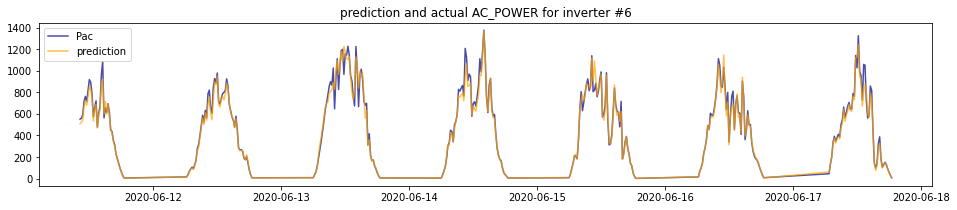

In [ ]:
plot_sample(plant1_predictions,6)

In [ ]:
def plot_all_residuals(prediction_df,figsize=(16,16),set_title=True):
    keys = np.unique(prediction_df['source_key'].values)
    cols = 4
    rows = len(keys)//cols + 1*(len(keys)>0)
    if rows == 1:
        cols = len(keys)
    fig ,axes = plt.subplots(nrows=rows,ncols=cols,figsize=figsize)
    if type(axes) == np.ndarray:
        axes = axes.ravel()
    else:
        axes = [axes]
    for key,ax in zip(keys, axes[:len(keys)]):
        key_df =  prediction_df[prediction_df['source_key']==key]
        residuals = key_df['residuals'].values
        plt.subplot(rows,cols,key+1)
        ax.hist(residuals, bins=50, density=True,color='navy',
                label = 'Residuals')
        if set_title == True:
            title = f"Residuals distribution for Inv #{key}"
            ax.set_title(title)
        xmin,xmax = ax.get_xlim()
        ymin,ymax = ax.get_ylim()
        xticks=np.linspace(xmin,xmax,5)
        labels=[f'{int(x)}' for x in xticks]
        plt.xticks(ticks=xticks,labels=labels)
        # make room for the legends
        plt.gca().set_xlim((xmin,xmax + (xmax-xmin)*0.65))
        plt.vlines(xmax,ymin,ymax,color='k')
        plt.gca().set_ylim((ymin,ymax))
        
        #draw legends
        n = len(residuals)
        mu = residuals.mean()
        m2 = np.sum(np.power(residuals-mu,2))/n
        m3 = np.sum(np.power(residuals-mu,3))/n
        m4 = np.sum(np.power(residuals-mu,4))/n
        mu = residuals.mean()
        sigma  = residuals.std()
        kurt = m4/(m2**2)
        skew = m3/(m2**1.5)
        rmse = int(np.sqrt(np.sum(np.power(residuals,2))/n))
        r2score = int(100*r2_score(key_df['pac'],key_df['pac_predicted']))
        legends = [ 
            f'     $\mu$ :' + f'{mu:0.1f}'.rjust(6," "),
            f'     $\sigma$ :' +  f'{sigma:0.1f}'.rjust(6," "),
            f'   kurt:' + f'{kurt:0.1f}'.rjust(6," "),
            f'skew:' + f'{skew:0.1f}'.rjust(6," "),
            f' rmse:' + f'{rmse}'.rjust(6," "),
            f'  R^2 :' + f'{r2score}%'.rjust(6," "),]
        for i,legend in enumerate(legends):
            plt.text(xmax + (xmax-xmin)*0.05,
                     ymax-(ymax-ymin)*(0.11*(i+1)), legend,color='navy')
            
    # do not show empty plots
    for i in range(rows*cols)[len(keys):]:
        axes[i].axis('off')
    fig.subplots_adjust(hspace=0.5)

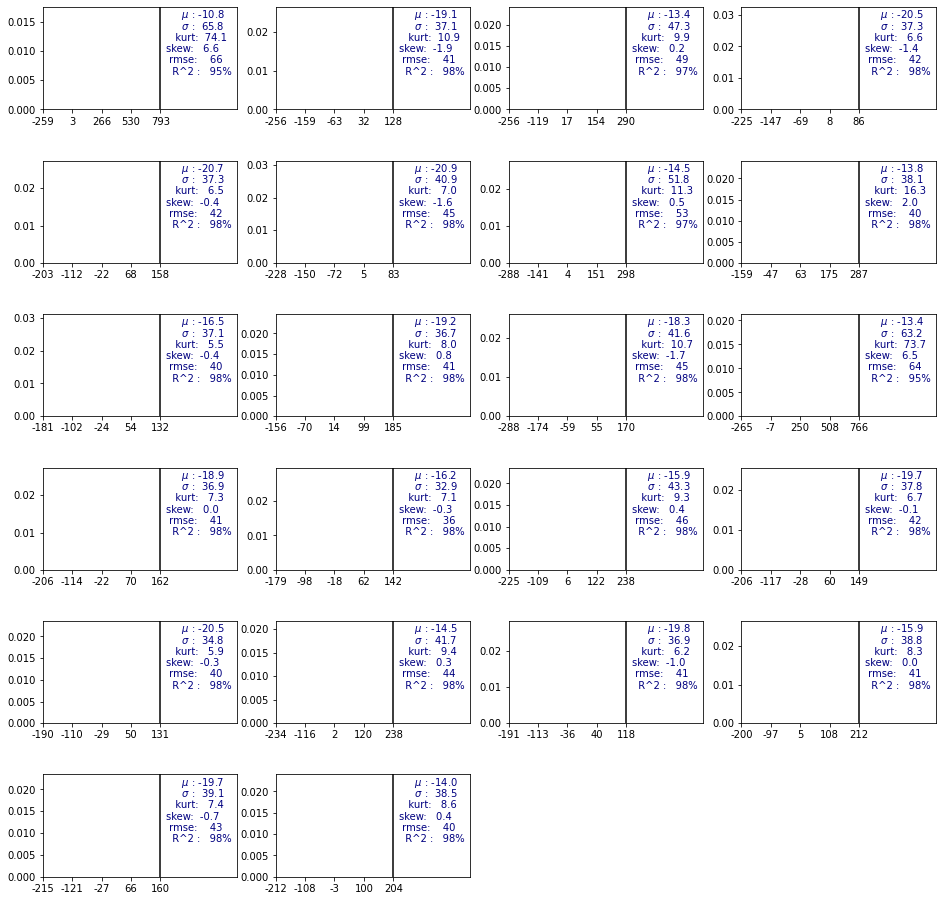

In [ ]:
plot_all_residuals(plant1_predictions)

                    Plant #1 Residuals distribution, and scores


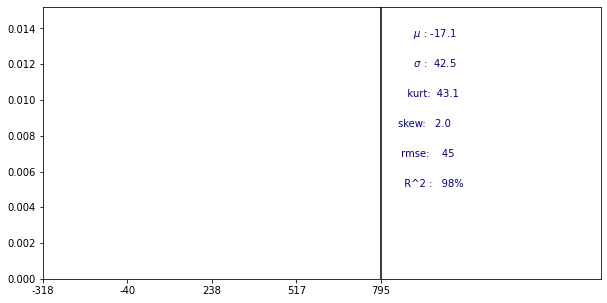

In [ ]:
# visualizing the complete Plant 1 residuals distribution
# i.e. all inverters residuals combined
print("                    Plant #1 Residuals distribution, and scores")
residuals_df = plant1_predictions.copy()
residuals_df['source_key'] = np.full(len(residuals_df['source_key']),0)
plot_all_residuals(residuals_df, figsize=(10,5),
                   set_title=False)

#### Findings:
<pre>
9- The predictions for plant #1 are accurate with a total <b>R2=98%</b>
   The residuals distributions have high kurtosis and left skewedness
   following what a priori looks to be a not normal Laplace distribution
   (see below) since it is derived from the difference between two random
   variables. 
</pre>
$$ \text{Standard Laplace distribution : }\frac{1}{2\beta}\large{e^{-\frac{|x-\mu|}{\beta}}} \color{white}{------}$$ 


In [ ]:
'''visualization of a Laplace distribution alongside with
all the residuals distribution for plant #1.
The positional variable "mu" (mean), "beta" (deviation)
and "K" (scale factor) can be modified interactively'''

@interact(mu = widgets.FloatSlider(min=-200,max=500,step=12,
                            value=400,desscription='$\mu$'),
          beta = widgets.FloatSlider(min=0.1,max=90,step=5,
                            value=25,desscription='$\beta$'),
          k = widgets.FloatSlider(min=0,max=300000,step=10000,
                            value=125000,desscription='$k$'),)
def plot_laplace_distribution(mu,beta,k):
    global residuals_df
    plt.figure(figsize=(8,5))
    x = np.linspace(mu-150,mu+150,50)
    y = (k/(2*beta))*np.exp(-abs(x-mu)/beta)
    plt.hist(residuals_df['residuals'], bins=50,color='navy',
             label = 'Residuals')
    plt.title("Laplace distribution and Residuals Distribution")
    plt.plot(x, y,"--",linewidth=3,color='orange',
             label='Laplace Distribution')
    plt.legend(loc='best')

interactive(children=(FloatSlider(value=400.0, description='mu', max=500.0, min=-200.0, step=12.0), FloatSlide…


#### Observations:
<pre>
w- To establish the confidence intervals for the residuals distributions
   an appropriate normal distribution needs to be characterized or an 
   appropriate transformation has to be applied due to the leptokurtic
   skewed nature of the distribution.
   To start it it can be modeled using a non standard Laplace Dist.
</pre>



<pre>
x- From the prediction of <b>AC-Power</b> the <b>daily_yield</b> and <b>total_yield</b> 
   can be obtained using the following equations:
</pre>
$$instant\_energy = E_n = \sum_\limits{i=0}^{n-1}\frac{Pac_i+Pac_{i+1}}{2}{\big (t_{i+1}-t_{i})} 
{\color{white}{-----------}}(6){\color{white}{-----------------------}}$$

$$daily\_yield_n = \begin{cases}
                        \quad 6:00 >= t <= 18:30; & =0\\
                         t < 6:00 \;\land\; t > 18:30\;\;; & \sum_\limits{i=0}^{n}E_i
                     \end{cases} {\color{white}{----------}}(7){\color{white}{-----------------------}}$$
                     
$$total\_yield_n = \sum_\limits{i=0}^{n}E_i  {\color{white}{-------------------------}}(8){\color{white}{-----------------------}}$$

In [ ]:
def get_total_yields(prod_df, prediction_df, key):
    plt.figure(figsize=(12,6))
    prod_df = prod_df[prod_df['source_key']==key]
    prediction_df = prediction_df[prediction_df['source_key']==key]
    merged_df = pd.merge(prod_df,prediction_df,on=['date_time'], how='inner')
    pac = merged_df['pac'].values
    date_time= pd.DatetimeIndex(merged_df['date_time'])
    time_delta = np.hstack([[0.25],(date_time[1:]-date_time[0:-1]).seconds/3600])
    pred_total_yield = np.hstack([[0],(pac[1:]+pac[0:-1])/2])
    pred_total_yield = np.cumsum(pred_total_yield*time_delta)
    plt.plot(date_time,pred_total_yield,label='predicted total_yield')
    
    prod_df = prod_df[prod_df['date_time']>=date_time[0]]
    total_yield = prod_df['total_yield'].values
    total_yield = total_yield - total_yield.min()
    plt.plot(prod_df['date_time'].values, total_yield, label='Dataset total_yield')

    
    daily_yield = prod_df['daily_yield'].values
    energy = np.hstack([[0],daily_yield[1:]-daily_yield[0:-1]])
    
    date_time = prod_df['date_time'].values
    date_time = date_time[energy>=0]
    energy    = energy[energy>=0]
    
    total_yield_from_dy = np.cumsum(energy)
    plt.plot(date_time[:-10], total_yield_from_dy[:-10],
             label='calculated total_yield from daily_yield')
    
    plt.legend()
    plt.show()

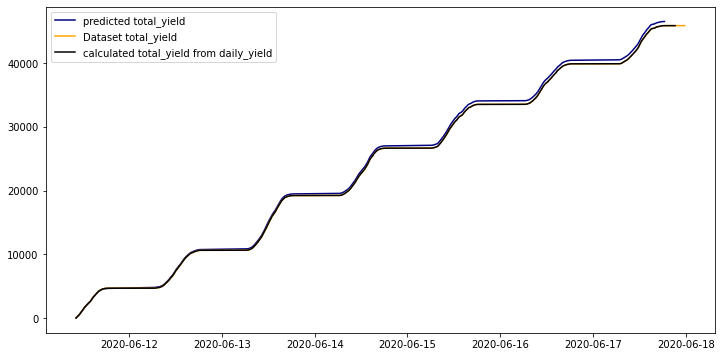

In [ ]:
get_total_yields(prod_p1, plant1_predictions,4)

#### Findings:
<pre>
10- The <b>total_yield</b> can be calculated from <b>daily_yield</b> and match the
    <b>calculated total_yield</b> from <b>daily_yield</b> (black and orange).
    The predicted one deviates slightly (blue) but for a period of
    3 days it seems to be accurate enough for practical purposes.
</pre>

<a id="section_6"></a>
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>Plant #1 Inverters and panels performance metrics.</b></font>
------------------------------------------------------------------------------
</font>
</pre>

In [ ]:
# Which is the inverter with more missing values ?

def plot_inverters_by_missing(supp_data, missing_data):
    
    md = missing_data.explode('source_key')['source_key'].values
    keys, counts = np.unique(md,return_counts=True)
    keys = pd.DataFrame({ 'keys':keys,'counts':counts, 
                    'source_key':supp_data['source_key']})
    keys.sort_values(by='counts', ignore_index=True, inplace=True)
    labels = []
    for ix in keys.index:
        label = keys.iloc[ix]['source_key']
        label += '   -   ' + f'{keys.iloc[ix]["keys"]}'.rjust(2,"0")
        labels+= [label]
    counts = sorted(counts)
    bar_colors = plt.cm.YlOrRd(np.linspace(0.05,.55,len(labels)))
    font_colors= plt.cm.Greys(np.linspace(0.3,.9,len(labels)))
    plt.figure(figsize=(7,5))
    plt.title(f"Plant ID #{supp_data['plant_id']} Missing entries by inverter",
              fontsize=16,ha='left',pad=20,position=(.005,1))
    plt.text(1,22.8,"from 15/May-2020 to 17/jun-2020")
    plt.xticks(ticks=[])
    plt.xlim([0,counts[-1]*1.1])
    bars = plt.barh( labels, counts , color=bar_colors)
    for b,color in zip(bars,font_colors):
        width = b.get_width()
        plt.annotate(f'{width}',xy=(width,b.get_y()+b.get_height()/2),xytext=(6,-3),
                    textcoords='offset points',c=color,fontsize=10)

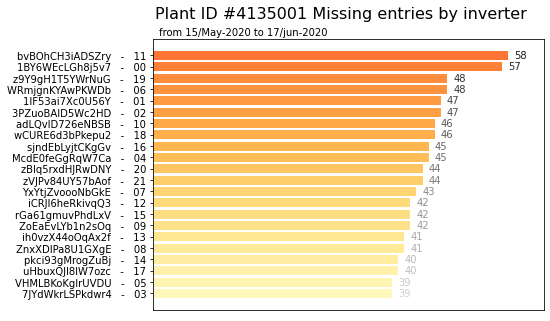

In [ ]:
plot_inverters_by_missing(prod_p1_supp_data, prod_p1_missing_data)

#### Findings:
<pre>
11- There are some inverters that have more missing entries during daytime.
    This can be an indicator of performance as it correlates to malfunction
    or downtime like it was mentioned in the observation <b>l-</b>. In this case
    for plant #1 the inverters 0 and 11 are the ones with the most missing
    entries and the #3 is the one with less.
</pre>

#### Observations:
<pre>
y- Dirt in the solar panels and or degradation can occur, this should be
   reflected as lower power output by irradiance unit from the sun.
</pre>

In [ ]:
# Which inverters (panels) have the lowest power/irradiance ratio?

def plot_avg_power_irradiance_ratio(prod_df, sensor_df):
    plt.figure(figsize=(14,4))
    key_df = pd.merge(left=sensor_df,right=prod_df,how='inner',
                      on='date_time')
    key_df = key_df[key_df['irradiation']>0]
    key_df['ratio']=key_df['ac_power']/key_df['irradiation']
    key_df = key_df.groupby(['source_key'], as_index=False).mean()
    key_df.sort_values(by='ratio',ascending=False,inplace=True)
    color_range = key_df['ratio']-key_df['ratio'].min()*1.02
    color_range = color_range/color_range.max()
    bar_colors = plt.cm.coolwarm_r(color_range)
    bars = plt.bar(key_df['source_key'].values.astype(np.str_),
            key_df['ratio'], color = bar_colors)
    plt.yticks(ticks=[])
    max_height = key_df['ratio'].values.max()
    plt.ylim([0,max_height*1.1])
    
    for b in bars:
        height = b.get_height()
        plt.annotate(f'{int(height)}',xy=(b.get_x()-b.get_width()/2,height),
                     xytext=(12,6), textcoords='offset points',fontsize=10)
        plt.annotate(f'{int(100*(height/max_height-1))}%',
                     xy=(b.get_x()-b.get_width()/2,max_height*2/3),
                     xytext=(15,0),textcoords='offset points',
                     backgroundcolor='w',fontsize=9)
    plt.xlabel("Inverters")
    plt.ylabel("Power / Irradiation")
    plt.title("power / irradiance ratio by inverter")
    plt.xticks(range(len(np.unique(prod_df['source_key'].values))))
    plt.show()

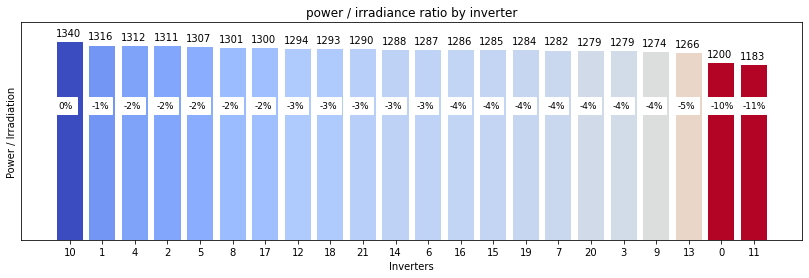

In [ ]:
plot_avg_power_irradiance_ratio(prod_p1,p1ws)

#### Findings:
<pre>
12- The inverters #0 and #11 are the ones with the lowest power/irradiance
    ratio with a 10% or more reduction in the power output per irradiance
    unit respect to the output in inverter #10 which has the highest
    performance in this metric with a value of 1340.
</pre>

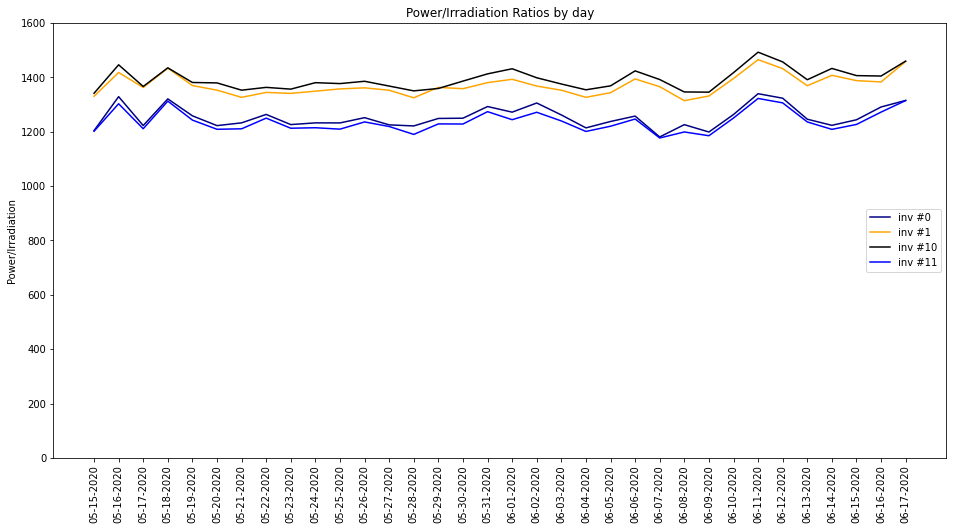

In [ ]:
# power irradiance by inverter
def plot_power_irr_ratio(prod_df, sensor_df, keys):
    plt.figure(figsize=(16,8))
    for i,key in enumerate(keys):
        key_df = prod_df[prod_df['source_key']==key]
        key_df = pd.merge(key_df,sensor_df, how='inner',on='date_time')
        key_df = key_df[key_df['irradiation']>0]
        key_df['ratio']  = key_df['ac_power']/key_df[ 'irradiation']
        key_df = key_df[key_df['ratio'] > 0]
        key_df['date_time'] = pd.DatetimeIndex(key_df['date_time']).strftime("%m-%d-%Y")
        key_df = key_df.groupby(by='date_time',as_index=False).mean()
        plt.plot(key_df['date_time'],key_df['ratio'],label=f'inv #{key}' )
        ax = plt.gca()
    ax.set_title("Power/Irradiation Ratios by day")
    ax.set_ylabel("Power/Irradiation")
    ax.legend(loc='center right')
    ax.set_ylim((0,1600))
    plt.xticks(key_df['date_time'],rotation=90)
plot_power_irr_ratio(prod_p1,p1ws,[0,1,10,11])

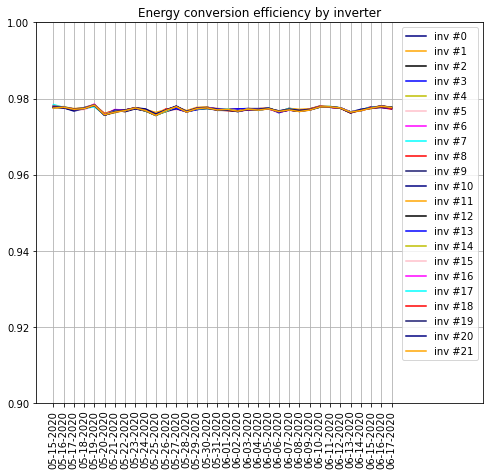

In [ ]:
# efficiency of every inverter
def plot_energy_convertsion_efficiency(prod_df):
    plt.figure(figsize=(8,7))
    for key in np.unique(prod_df['source_key'].values):
        key_df = prod_df[prod_df['source_key'] == key]
        key_df = key_df[key_df['dc_power']>0]
        key_df['date_time' ] = pd.DatetimeIndex(key_df['date_time']).strftime("%m-%d-%Y")
        key_df['efficiency'] = key_df['ac_power']/key_df['dc_power']
        key_df = key_df[(key_df['efficiency'] < 1) & (key_df['efficiency']  > 0.9)]
        key_df = key_df.groupby(by='date_time',as_index=False).mean()
        plt.plot(key_df['date_time'],key_df['efficiency'],label=f"inv #{key}")
    plt.xticks(key_df['date_time'],rotation=90)
    plt.title("Energy conversion efficiency by inverter")
    plt.ylim((0.9,1.))
    xmin,xmax = plt.gca().get_xlim()
    plt.xlim([xmin,xmax+(xmax-xmin)*0.2])
    plt.grid()
    plt.legend(loc='best')
plot_energy_convertsion_efficiency(prod_p1)

#### Observations:
<pre>
z- No noticeable difference or anomalies can be appreciated in the
   inverters efficiency in the plant #1, neither any noticeable trend in
   the power/irradiance ratios average by day other than the obvious
   difference between each inverter.
</pre>

<a id="section_7"></a>
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>plant #2 Power modeling and prediction.</b></font>
------------------------------------------------------------------------------
</font>
</pre>

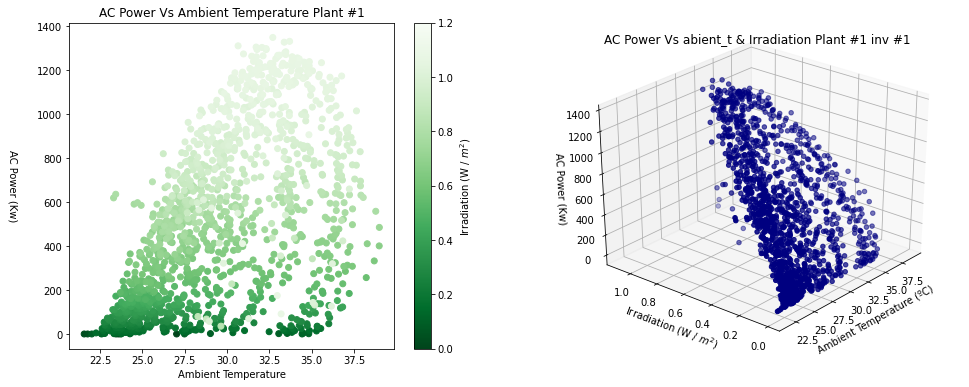

In [ ]:
power_vs_irr_vs_temp(p2ws,prod_p2,1)

In [ ]:
prod_p2_new_data = create_new_features(prod_p2,p2ws,1)
prod_p2_new_data.head()

,date_time,hours,Gir^3,Gir^2,Gir^2.Ta,Gir.Ta^2,Gir.Ta,Gir,pac
24,2020-05-15 06:00:00,6.00,0.000002,0.000168,0.004157,7.935394,0.320715,0.012962,14.246667
25,2020-05-15 06:15:00,6.25,0.000009,0.000443,0.010960,12.901377,0.520975,0.021038,24.353333
26,2020-05-15 06:30:00,6.50,0.000076,0.001801,0.044634,26.070688,1.051818,0.042435,53.614286
27,2020-05-15 06:45:00,6.75,0.001109,0.010711,0.268302,64.934823,2.592390,0.103496,145.606667
28,2020-05-15 07:00:00,7.00,0.007934,0.039780,1.021293,131.460472,5.120533,0.199450,286.893333


In [ ]:
( plant2_models, plant2_predictions,
plant2_rmses ) = construct_models(prod_p2, p2ws)

# 0   --->    rmse: 127,      R^2 (Determination coeff.): 78%
# 1   --->    rmse: 58,      R^2 (Determination coeff.): 96%
# 2   --->    rmse: 56,      R^2 (Determination coeff.): 96%
# 3   --->    rmse: 107,      R^2 (Determination coeff.): 80%
# 4   --->    rmse: 84,      R^2 (Determination coeff.): 92%
# 5   --->    rmse: 66,      R^2 (Determination coeff.): 95%
# 6   --->    rmse: 42,      R^2 (Determination coeff.): 97%
# 7   --->    rmse: 91,      R^2 (Determination coeff.): 85%
# 8   --->    rmse: 86,      R^2 (Determination coeff.): 91%
# 9   --->    rmse: 91,      R^2 (Determination coeff.): 90%
#10   --->    rmse: 111,      R^2 (Determination coeff.): 77%
#11   --->    rmse: 106,      R^2 (Determination coeff.): 76%
#12   --->    rmse: 87,      R^2 (Determination coeff.): 87%
#13   --->    rmse: 56,      R^2 (Determination coeff.): 97%
#14   --->    rmse: 91,      R^2 (Determination coeff.): 91%
#15   --->    rmse: 88,      R^2 (Determination coeff.): 87%
#16   --->    rmse: 

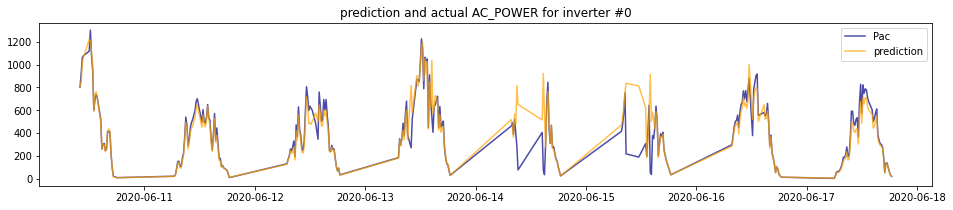

In [ ]:
plot_sample(plant2_predictions,0)

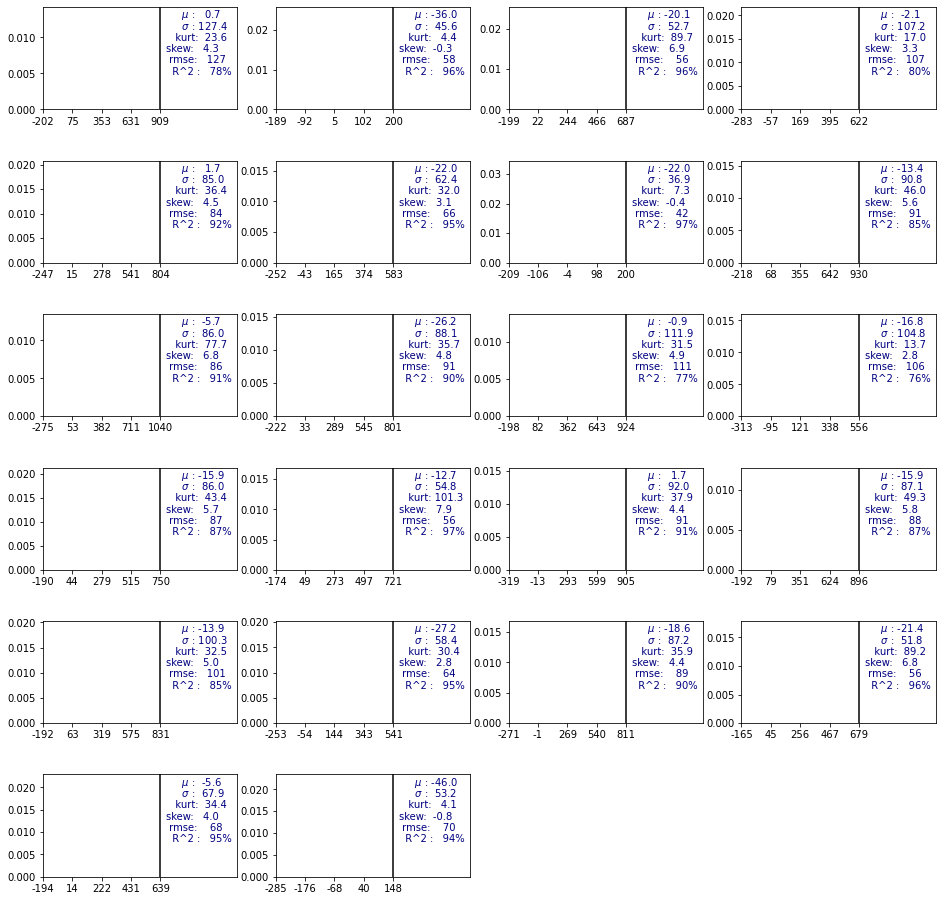

In [ ]:
plot_all_residuals(plant2_predictions)

                 Plant #2 Residuals distribution and scores 


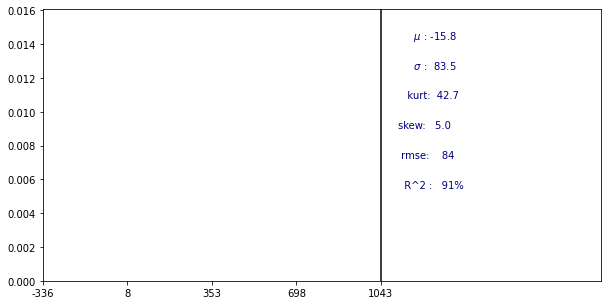

In [ ]:
# visualizing the complete Plant 1 residuals distribution
# i.e. all inverters residuals combined

print("                 Plant #2 Residuals distribution and scores ")
residuals_df = plant2_predictions.copy()
residuals_df['source_key'] = np.full(len(residuals_df['source_key']),0)
plot_all_residuals(residuals_df, figsize=(10,5),
                   set_title=False)

#### Findings:
<pre>
13- The RMSE for the models of plant #2 inverters are higher than the
    ones on plant #1 probably because of the higher quality of the
    plant #1 data. The same can be seen in the <b>R^2 score</b> (Det. coef.)
    that in some cases like inverters 0,10,11. Fall below 80%.
    Despite the situation the Plant #2 results can be considered as a
    whole at the plant level as accurate due to the overall R^2 = 91%
    and therefore are usable for prediction. Moreover tey can be
    improved as will  be shown in the <b>"Further opportunities for
    improvement"</b> section.
</pre>

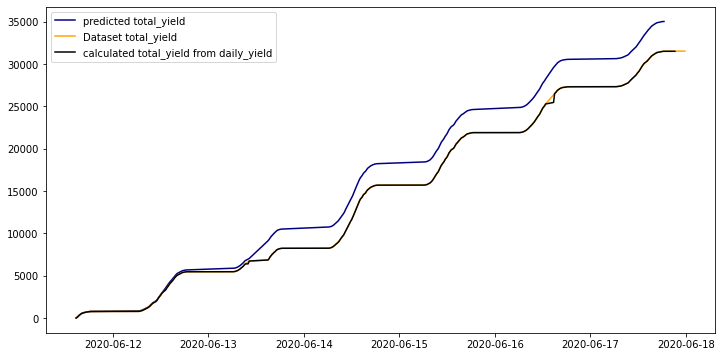

as 


In [ ]:
get_total_yields(prod_p2, plant2_predictions,2)
print("as ")

#### Findings:
<pre>
14- In many cases for the plant #2 the predicted <b>total_yield</b> deviates
    from the actual value largely, because of missing production. It
    should be seen not as a failure in the prediction but instead as
    a failure in the plant production due to unexpected downtime.
</pre>

<a id="section_8"></a>
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>Plant #2 Inverters and panels performance metrics.</b></font>
------------------------------------------------------------------------------
</font>
</pre>

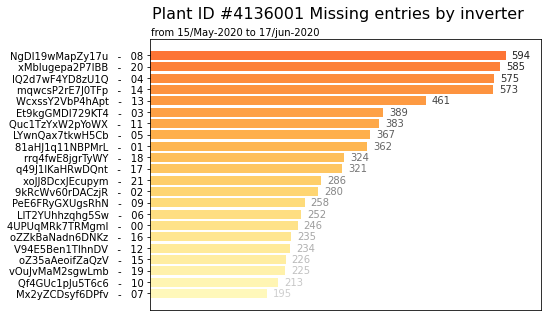

In [ ]:
plot_inverters_by_missing(prod_p2_supp_data, prod_p2_missing_data)

#### Findings:
<pre>
15- Inverter 4, 8, 14 & 20 are the ones with the highest incidence of
    missing time stamps and therefore probably the ones with more downtime
    and failures.
</pre>

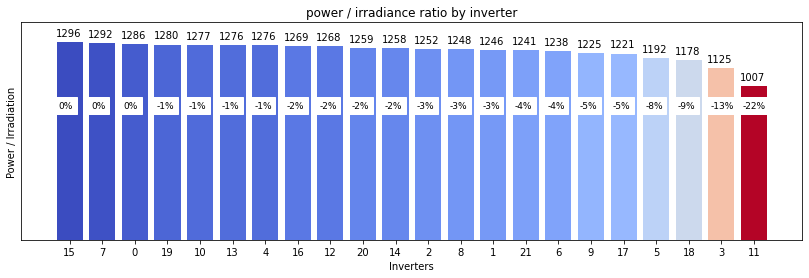

In [ ]:
plot_avg_power_irradiance_ratio(prod_p2,p2ws)

#### Findings:
<pre>
16- The inverters 3, 5, 11, 18 are the ones with the lowest performance.
    Being #11 at a critical -22% below the highest performing one which is
    #15 at a ratio of 1300.
</pre>

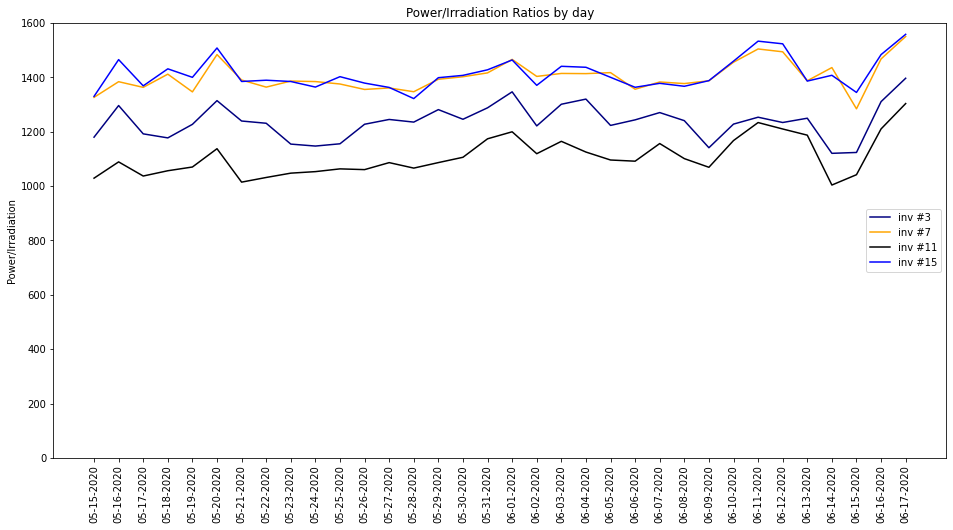

In [ ]:
# power irradiance by inverter

plot_power_irr_ratio(prod_p2,p2ws,[3,7,11,15])

#### Observations:
<pre>&alpha;- The trend of the lowest performing inverter #11 seems to have an
   improving trend during this period of time. That might be a indicative
   that something changed either by human intervention (manual cleaning) or
   weather (rain).
</pre>

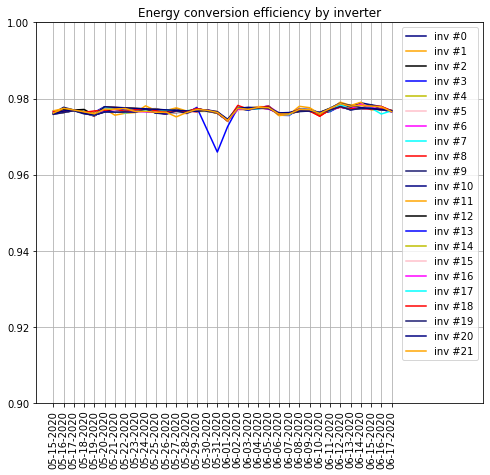

In [ ]:
# efficiency of every inverter

plot_energy_convertsion_efficiency(prod_p2)

#### Observations:
<pre>
&beta;- No noticeable difference can be appreciated in the inverters efficiency
   a single sudden change in the inverter #3 between days 5/31 and 6/01 can
   be seen, But not strong indication of malfunctions, rather it can be a 
   data related problem. Either way is small enough to be ignored.
</pre>

<a id="section_9"></a>
<pre>
  <font color = '#FF7722'>
------------------------------------------------------------------------------
<font size='5'><b>Conclusions.</b></font>
------------------------------------------------------------------------------
</font></pre>

##### 1-) Accurate models can be deviced using these datasets.
<pre>
Regression models can be created to predict the <b>AC Power, Daily_yield</b>
and <b>total yield</b> using <b>ambient temperature</b> and <b>ground irradiation</b> as 
hypothesized weather forecast data obtained previously to the power 
production. Thus demonstrating as a proof of concept that this type of data 
can be used to predict accurately with at least three days of anticipation 
if accurate enough ambient temperature and irradiation forecasts are 
provided.
</pre>

##### 2-) Many conditions of the plant can be diagnosed using this dataset.
<pre>
This data is also valuable and usable to detect systemic or specific 
failure modes and provide performance metrics of the individual inverters
that serve as diagnostic tools such as:
   • Power irradiation ratio: Diagnostic for panels dirtyness/degradation.
   • Missing production: Diagnostic for downtime/failure modes.
   • Energy conversion efficiency: Diagnostic for inverters overheating.
</pre>
